<h1 align="center"> Auto insurance - Training dataset </h1>

In [1]:
!pip install seaborn

In [2]:
!pip install imblearn

In [3]:
import numpy as np
import pandas as pd
import re

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import scipy.stats
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import PredictionErrorDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

## Goal of the project : 
The objective of calculating an annual third-party premium (material + bodily) for the 36,311 contracts in the 2011 pricing dataset :
Indeed, we will determine the cost of third-party insurance for each contract on an annual basis. This premium is intended to cover material and bodily damages caused to third parties in the event of an accident where the insured party is at fault.


#### Step 1. Data cleaning

In [7]:
# Load the training dataset
training_data = pd.read_csv('training.csv', sep=';')

In [8]:
# Display the first rows of the training dataset to understand its structure
print("Training Dataset:")
training_data.head()

Training Dataset:


PolNum  CalYear  Gender Type Category  Occupation  Age  Group1  Bonus  \
1  200114978     2009    Male    C    Large    Employed   25      18     90   
2  200114994     2009    Male    E    Large    Employed   20      11     30   
3  200115001     2009  Female    E    Large  Unemployed   42      11    150   
4  200115011     2009  Female    C   Medium   Housewife   21       5      0   
5  200115015     2009  Female    D    Large    Employed   33      12     30   

   Poldur  Value  Adind SubGroup2 Group2     Density  Exppdays  Numtppd  \
1       3  15080      0       L46      L   72.012883       365        1   
2       2  22370      1       O38      O   39.550411       365        1   
3       0  39650      0       Q28      Q  169.529148       365        2   
4       0  12600      1        L6      L   58.894688       365        1   
5      10   9065      0        N4      N  109.631885       365        2   

   Numtpbi  Indtppd  Indtpbi  
1        0      0.0      0.0  
2        0      0.0      0.0  
3        0      0.0      0.0  
4        0      0.0      0.0  
5        0      0.0      0.0

The training dataset contains:

100,000 unique insurance contracts for the years 2009 and 2010e:
Here is a description of each column in the dataset.

| Column     | Description                                                                  |
|------------|------------------------------------------------------------------------------|
| PolNum     | Contract number                                                              |
| CalYear    | Subscription year                                                            |
| Gender     | Gender of the vehicle driver                                                 |
| Type       | Type of car                                                                  |
| Category   | Car category                                                                 |
| Occupation | Driver's occupation                                                          |
| Age        | Driver's age                                                                 |
| Group1     | Car group                                                                    |
| Bonus      | Bonus-Malus (a discount or surcharge applied based on the claims history)   |
| Poldur     | Age of the insurance contract                                                |
| Value      | Value of the insured vehicle                                                 |
| Adind      | Indicator for material coverage                                              |
| SubGroup2  | Driver's home sub-region                                                     |
| Group2     | Driver's home region                                                         |
| Density    | Population density                                                           |
| Expdays    | Exposure (in days)                                                           |
| Numtppd    | Number of third-party material claims                                        |
| Numtpbi    | Number of third-party bodily injury claims                                   |
| Indtppd    | Total cost of third-party material claims                                    |
| Indtpbi    | Total cost of third-party bodily injury claims                               |


In [9]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100021 entries, 1 to 100021
Data columns (total 20 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   PolNum      100021 non-null  int64  
 1   CalYear     100021 non-null  int64  
 2   Gender      100021 non-null  object 
 3   Type        100021 non-null  object 
 4   Category    100021 non-null  object 
 5   Occupation  100021 non-null  object 
 6   Age         100021 non-null  int64  
 7   Group1      100021 non-null  int64  
 8   Bonus       100021 non-null  int64  
 9   Poldur      100021 non-null  int64  
 10  Value       100021 non-null  int64  
 11  Adind       100021 non-null  int64  
 12  SubGroup2   100021 non-null  object 
 13  Group2      100021 non-null  object 
 14  Density     100021 non-null  float64
 15  Exppdays    100021 non-null  int64  
 16  Numtppd     100021 non-null  int64  
 17  Numtpbi     100021 non-null  int64  
 18  Indtppd     100021 non-null  float64
 19  Indtpbi

In [10]:
# Check for missing values in the training dataset
print("\nMissing Values in Training Dataset:")
print(training_data.isnull().sum())


Missing Values in Training Dataset:
PolNum        0
CalYear       0
Gender        0
Type          0
Category      0
Occupation    0
Age           0
Group1        0
Bonus         0
Poldur        0
Value         0
Adind         0
SubGroup2     0
Group2        0
Density       0
Exppdays      0
Numtppd       0
Numtpbi       0
Indtppd       0
Indtpbi       0
dtype: int64


In [11]:
# Check for duplicates in the training dataset
print("\nDuplicates in Training Dataset:")
print(training_data.duplicated().sum())


Duplicates in Training Dataset:
0


In [12]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


PolNum        CalYear            Age         Group1  \
count  1.000210e+05  100021.000000  100021.000000  100021.000000   
mean   2.002003e+08    2009.499895      41.122514      10.692625   
std    6.217239e+04       0.500002      14.299349       4.687286   
min    2.001149e+08    2009.000000      18.000000       1.000000   
25%    2.001399e+08    2009.000000      30.000000       7.000000   
50%    2.001649e+08    2009.000000      40.000000      11.000000   
75%    2.002608e+08    2010.000000      51.000000      14.000000   
max    2.002858e+08    2010.000000      75.000000      20.000000   

               Bonus         Poldur          Value          Adind  \
count  100021.000000  100021.000000  100021.000000  100021.000000   
mean       -6.921646       5.470781   16454.675268       0.512142   
std        48.633165       4.591194   10506.742732       0.499855   
min       -50.000000       0.000000    1000.000000       0.000000   
25%       -40.000000       1.000000    8380.000000       0.000000   
50%       -30.000000       4.000000   14610.000000       1.000000   
75%        10.000000       9.000000   22575.000000       1.000000   
max       150.000000      15.000000   49995.000000       1.000000   

             Density       Exppdays        Numtppd        Numtpbi  \
count  100021.000000  100021.000000  100021.000000  100021.000000   
mean      117.159270     327.588007       0.147449       0.046790   
std        79.500907      73.564636       0.436917       0.219546   
min        14.377142      91.000000       0.000000       0.000000   
25%        50.625783     340.000000       0.000000       0.000000   
50%        94.364623     365.000000       0.000000       0.000000   
75%       174.644525     365.000000       0.000000       0.000000   
max       297.385170     365.000000       7.000000       3.000000   

             Indtppd        Indtpbi  
count  100021.000000  100021.000000  
mean      106.135007     222.762829  
std       444.949188    1859.422836  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       0.000000  
75%         0.000000       0.000000  
max     12878.369910   69068.026292

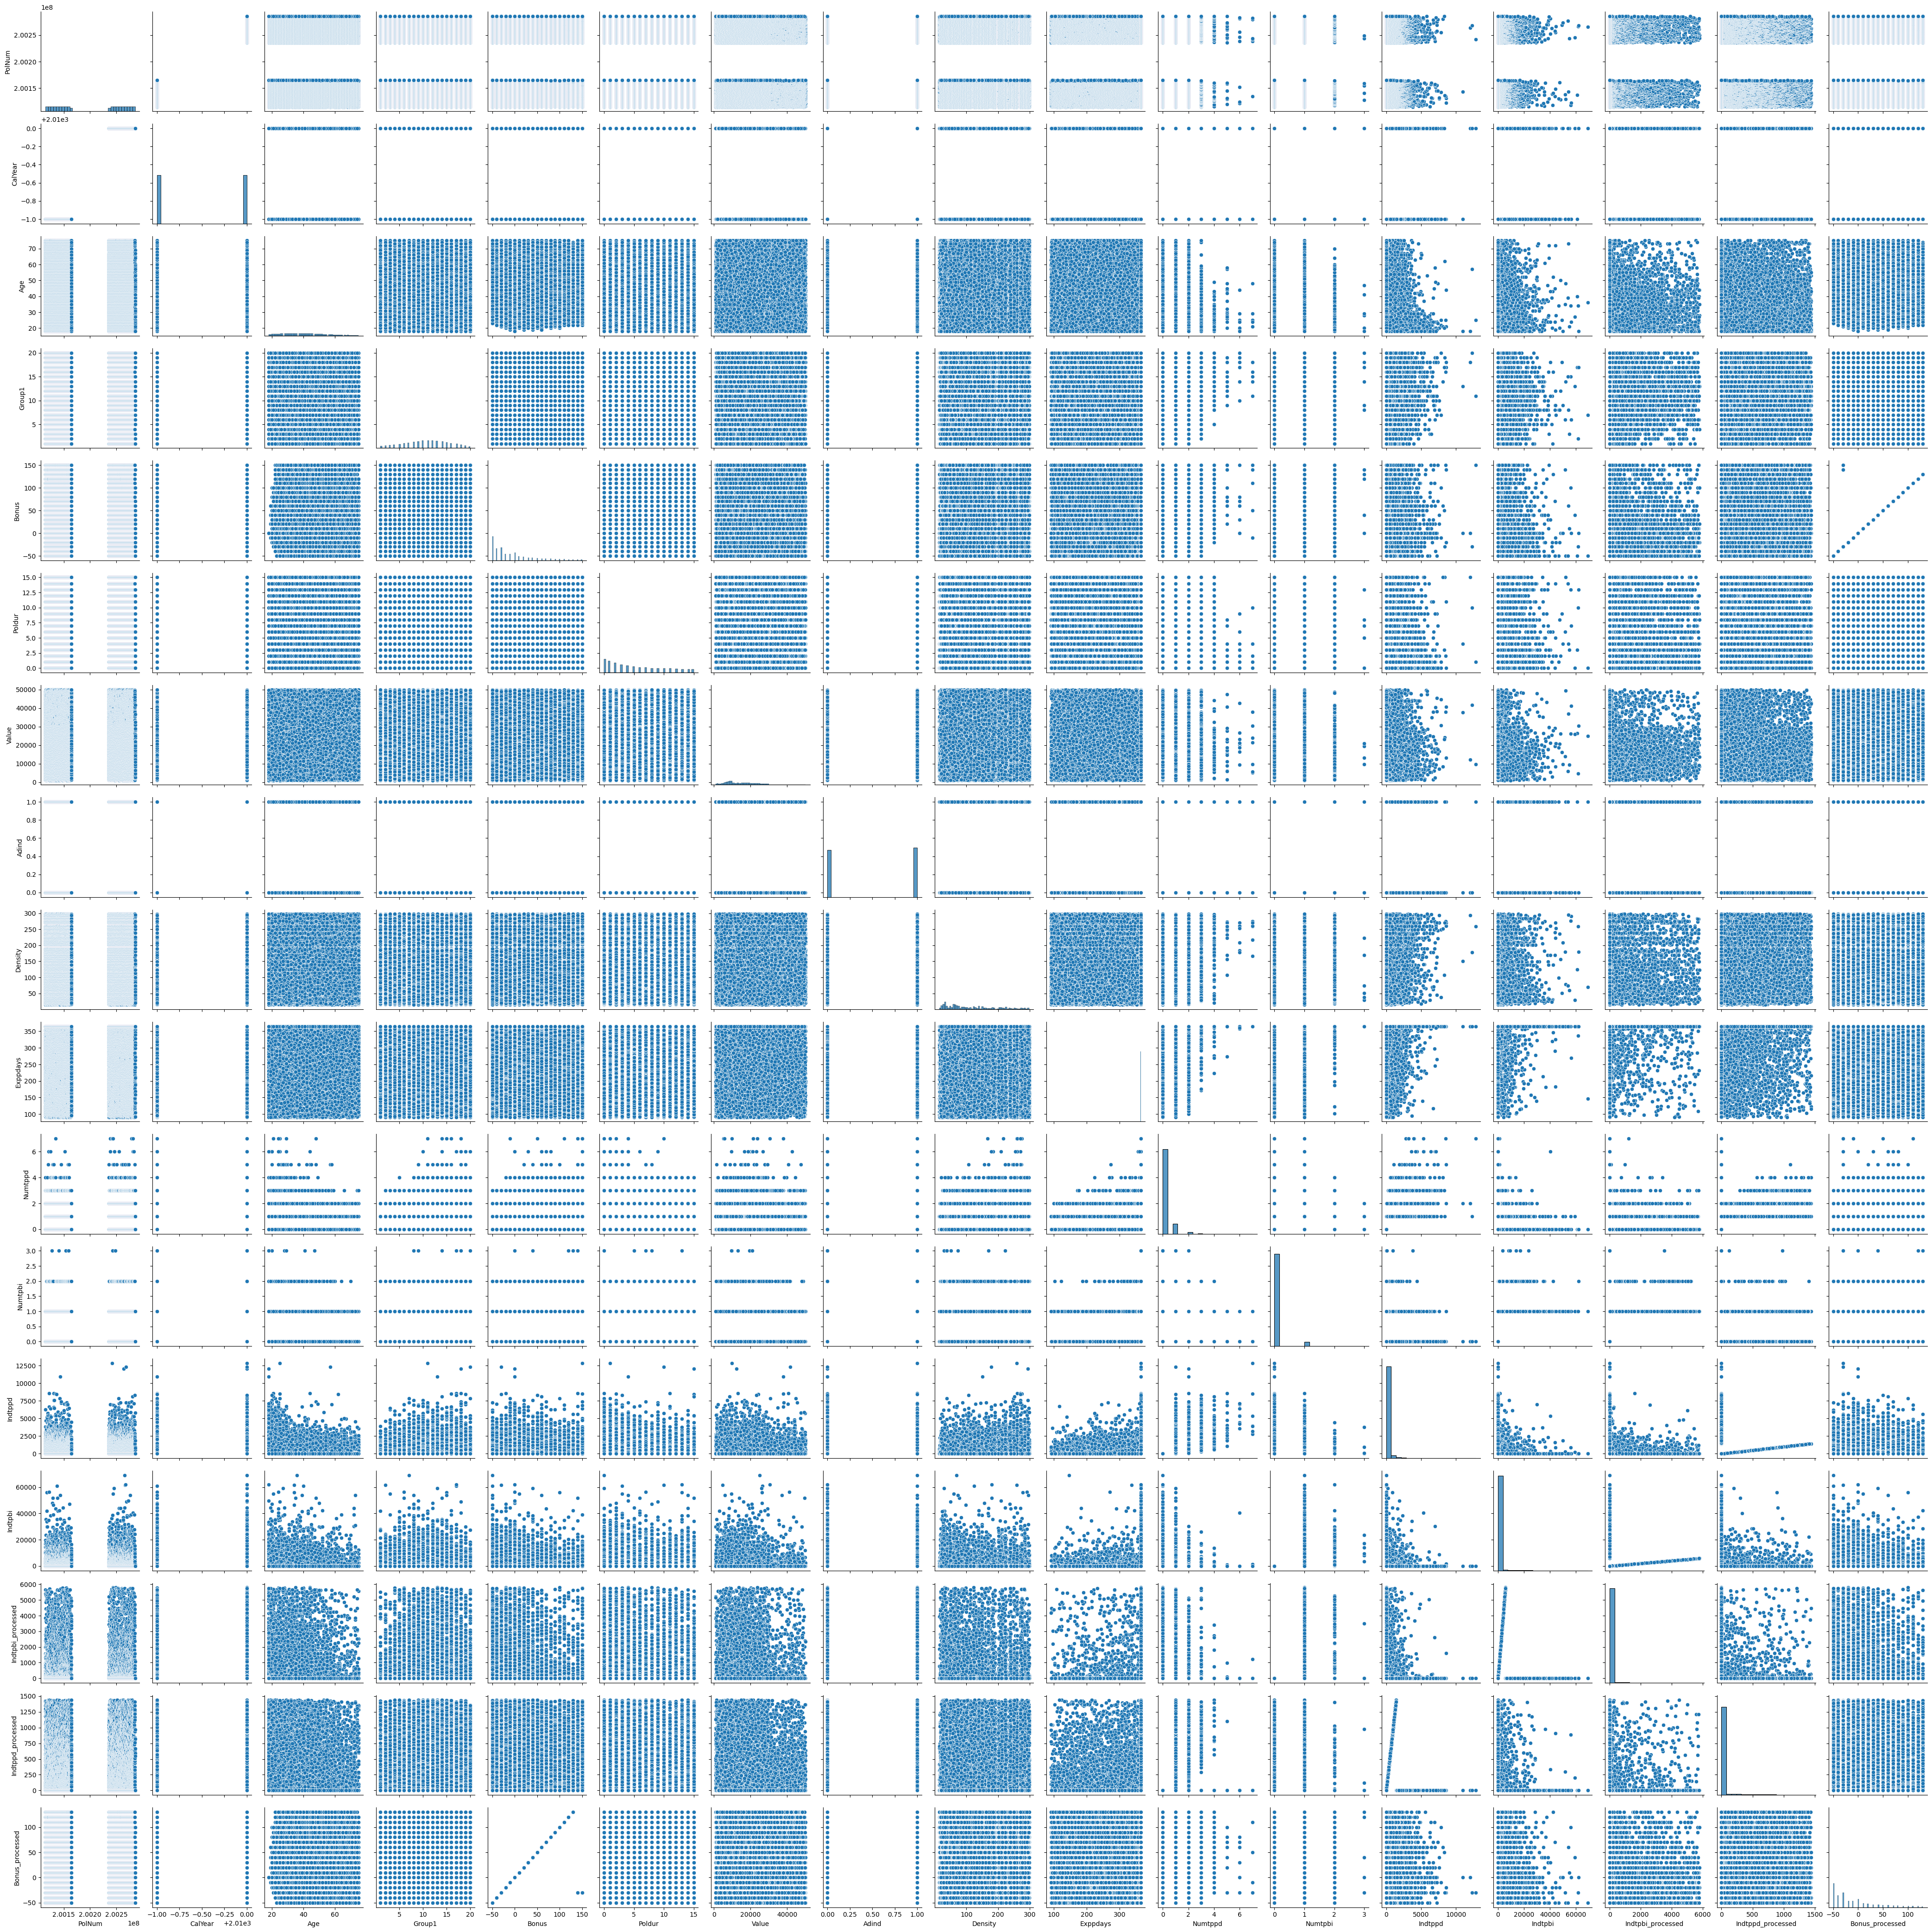

In [120]:
%matplotlib inline
import seaborn as sns
sns.pairplot(training_data)

#### Step 2. Data exploration

##### **1. Univariate Data Analysis**

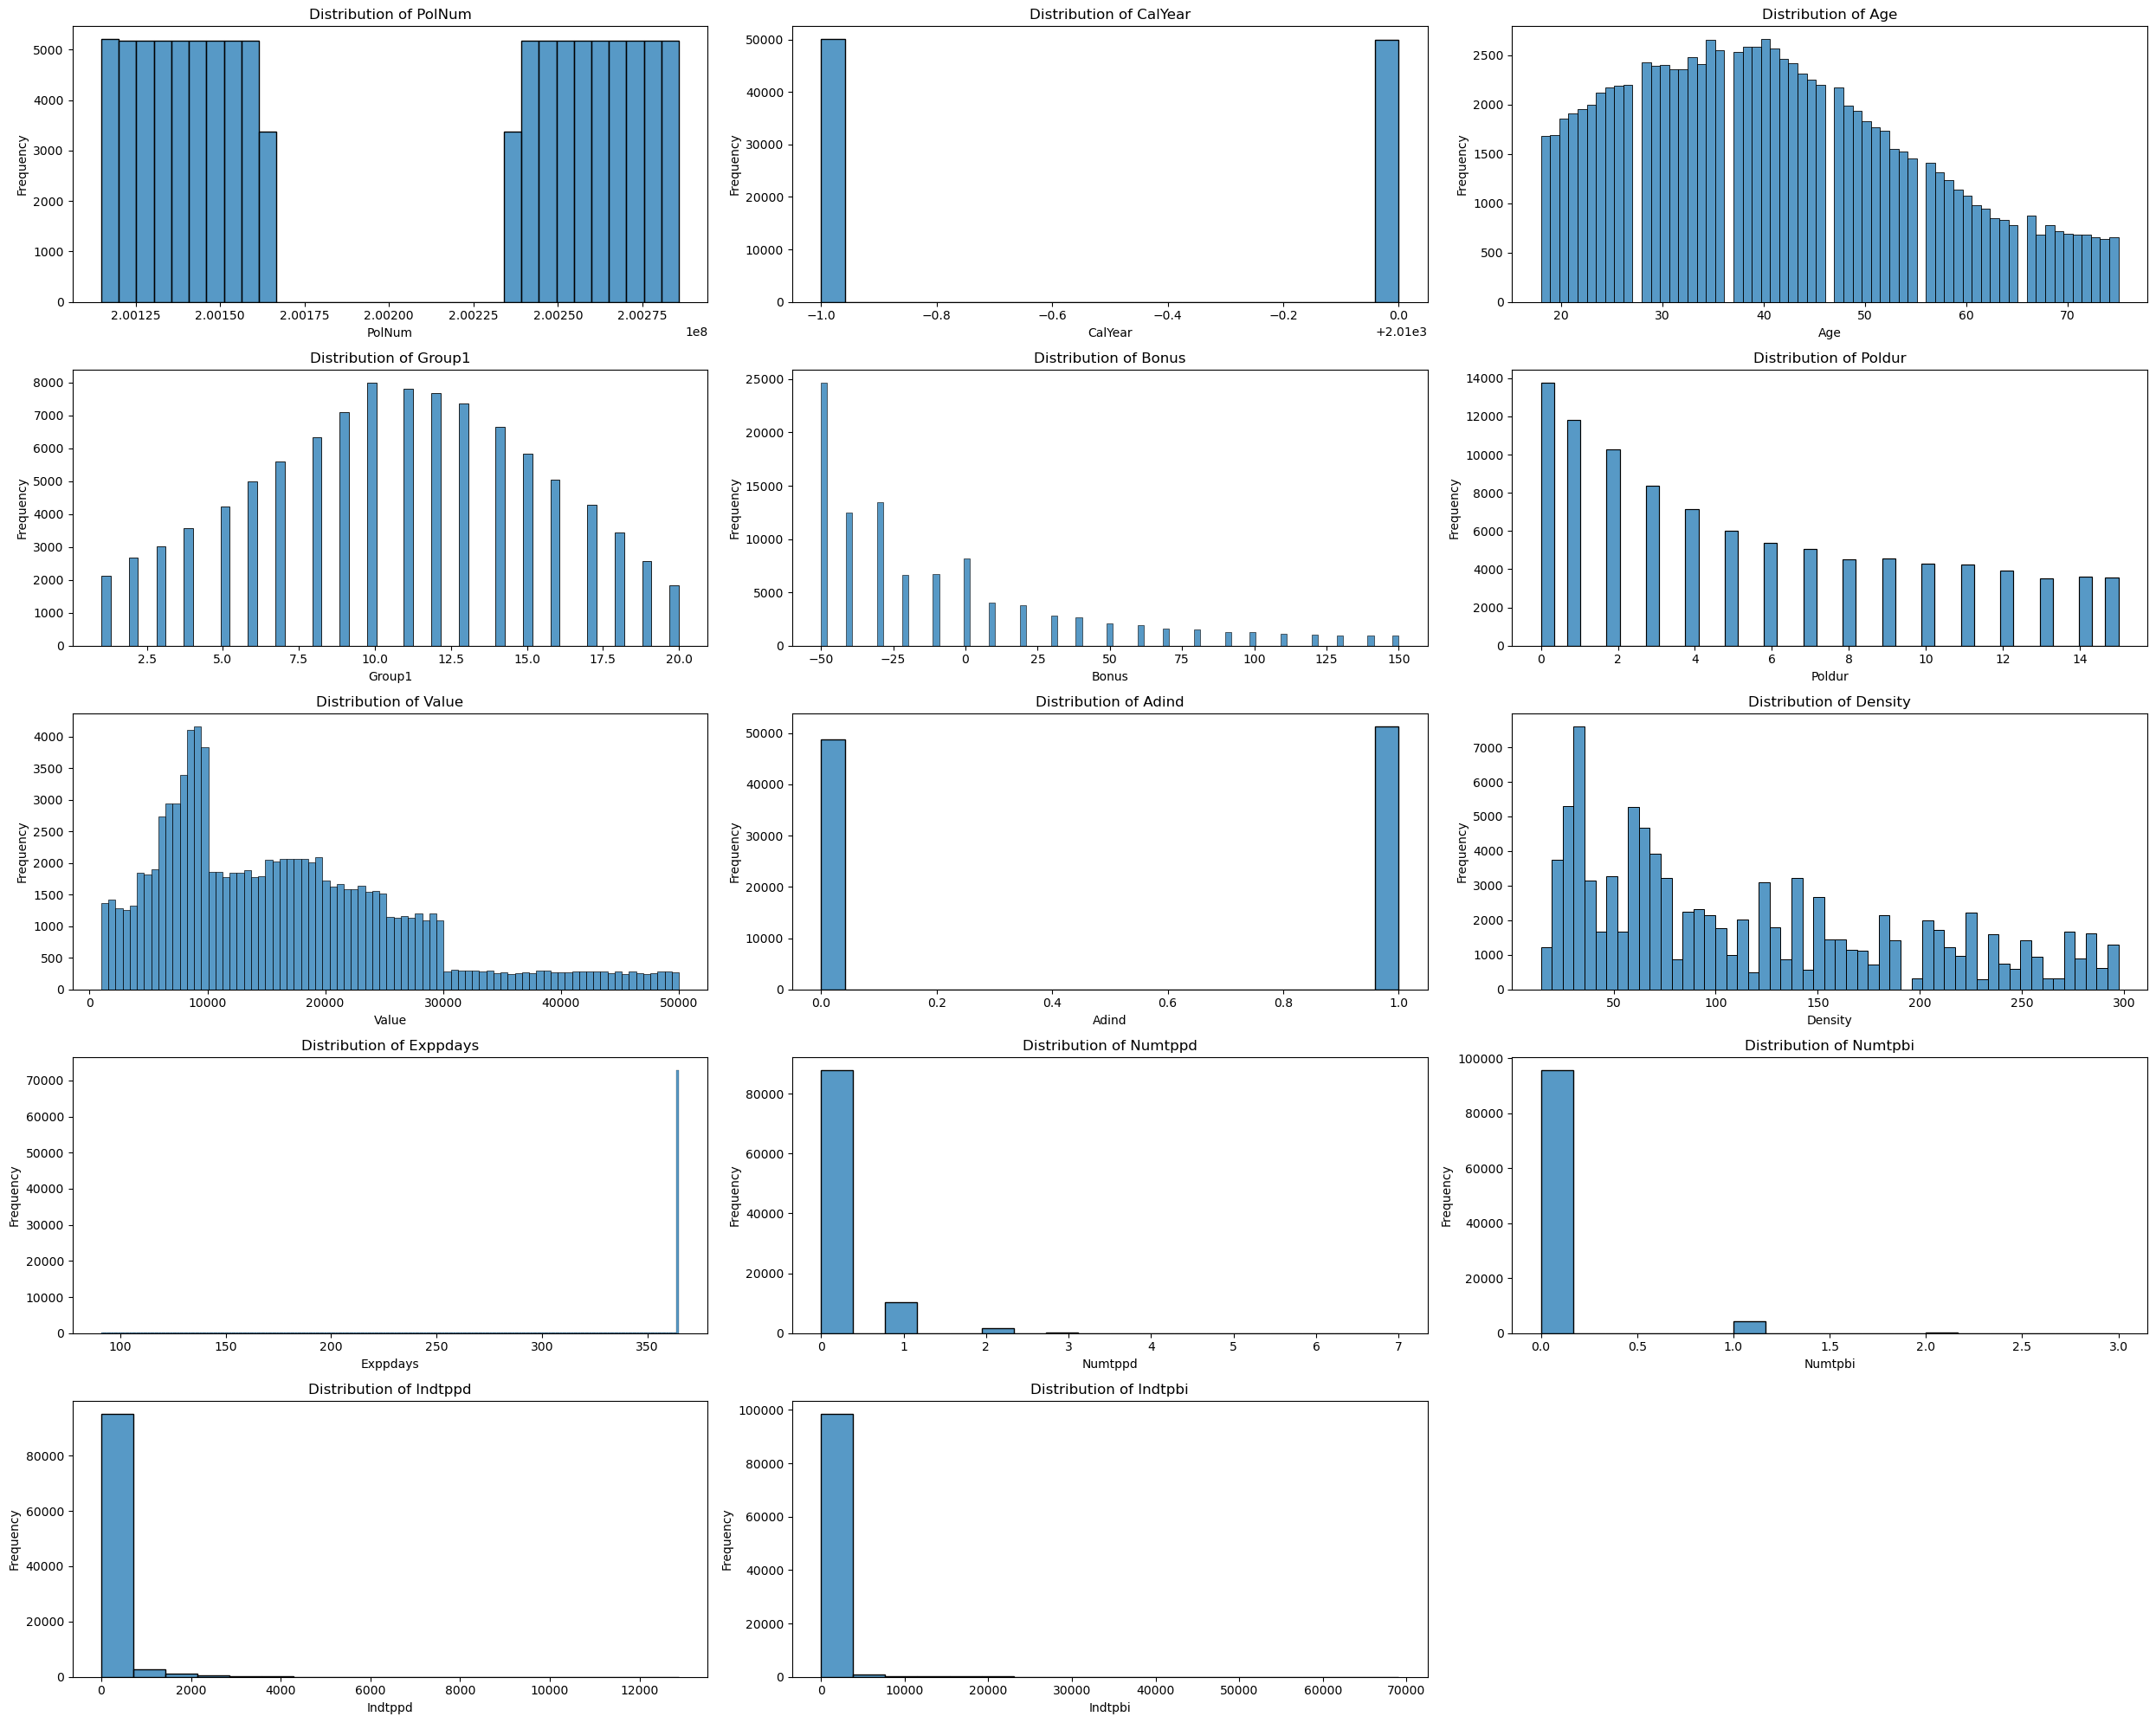

In [13]:
# Univariate analysis for numerical variables
numerical_vars = training_data.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(numerical_vars) - 1) // num_cols + 1  # Number of rows

# Distribution plots for numerical variables
plt.figure(figsize=(25, 20))
for i, var in enumerate(numerical_vars):
    plt.subplot(num_rows, num_cols, i+1)
    sns.histplot(training_data[var], kde=False)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

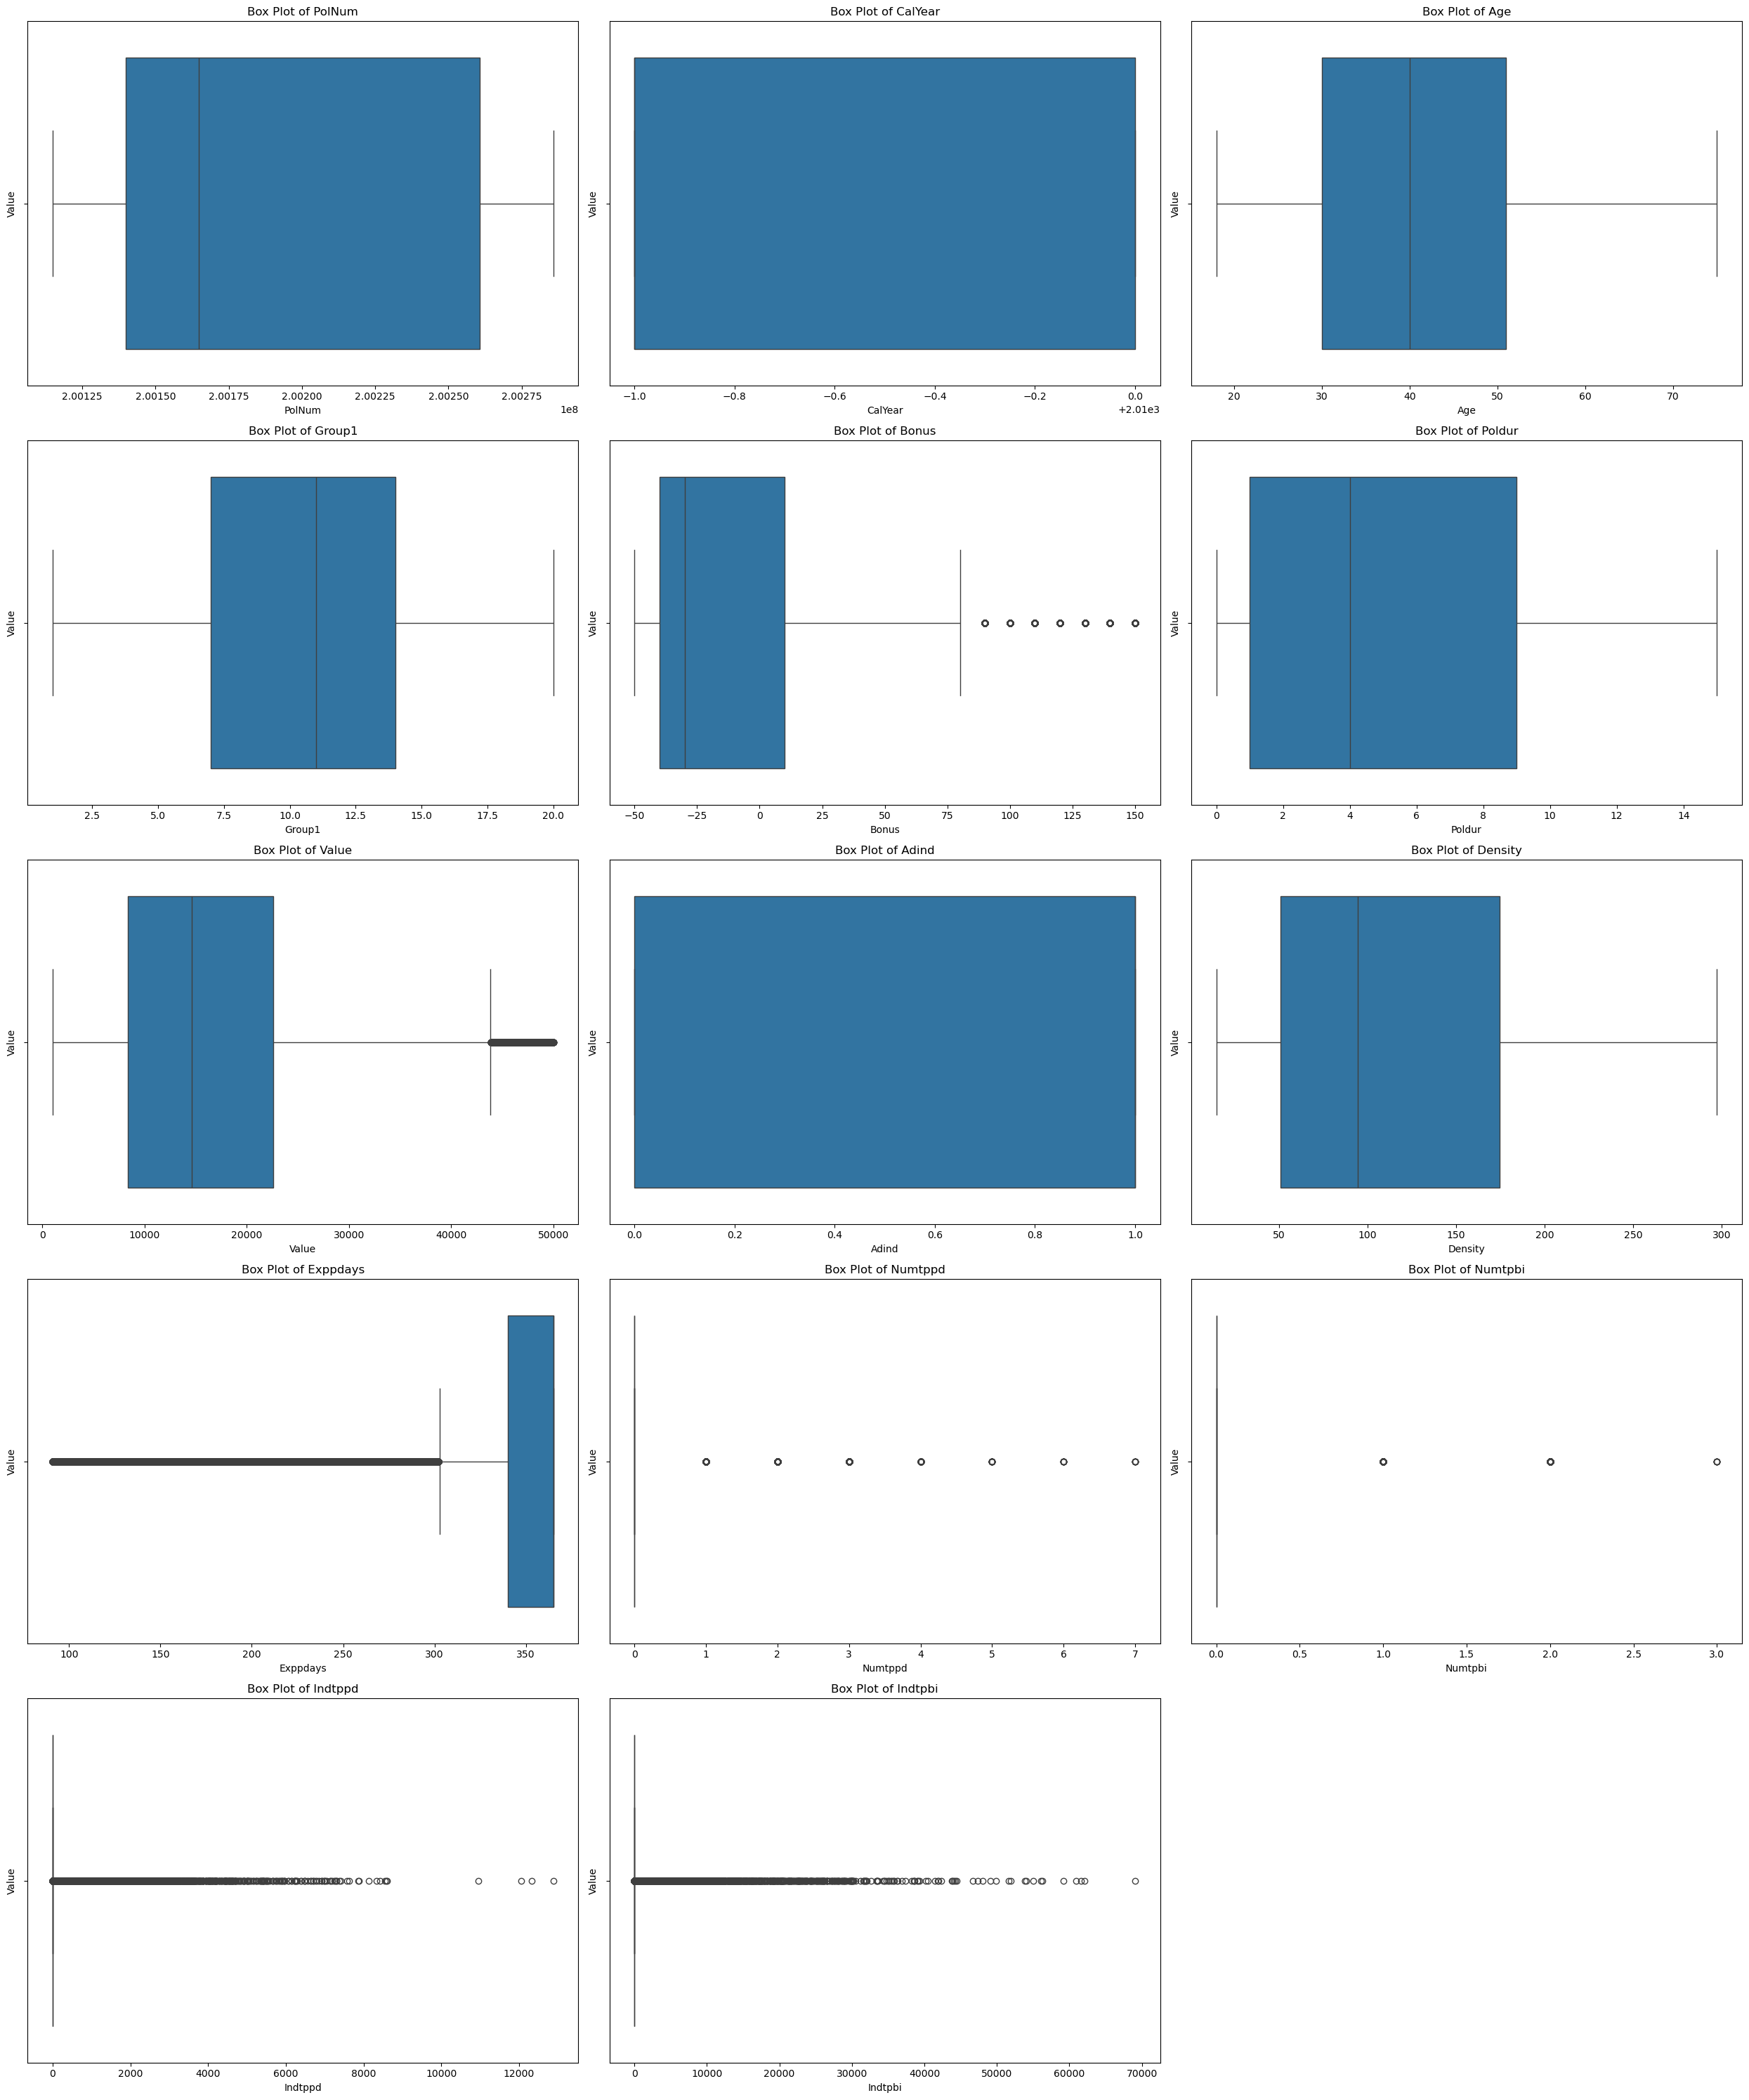

In [14]:
# Univariate analysis for numerical variables
numerical_vars = training_data.select_dtypes(include=[np.number]).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(numerical_vars) - 1) // num_cols + 1  # Number of rows

# Box plots for numerical variables
plt.figure(figsize=(25, 30))
for i, var in enumerate(numerical_vars):
    plt.subplot(num_rows, num_cols, i+1)
    sns.boxplot(x=var, data=training_data)
    plt.title(f'Box Plot of {var}')
    plt.xlabel(var)
    plt.ylabel('Value')
plt.tight_layout()
plt.show()

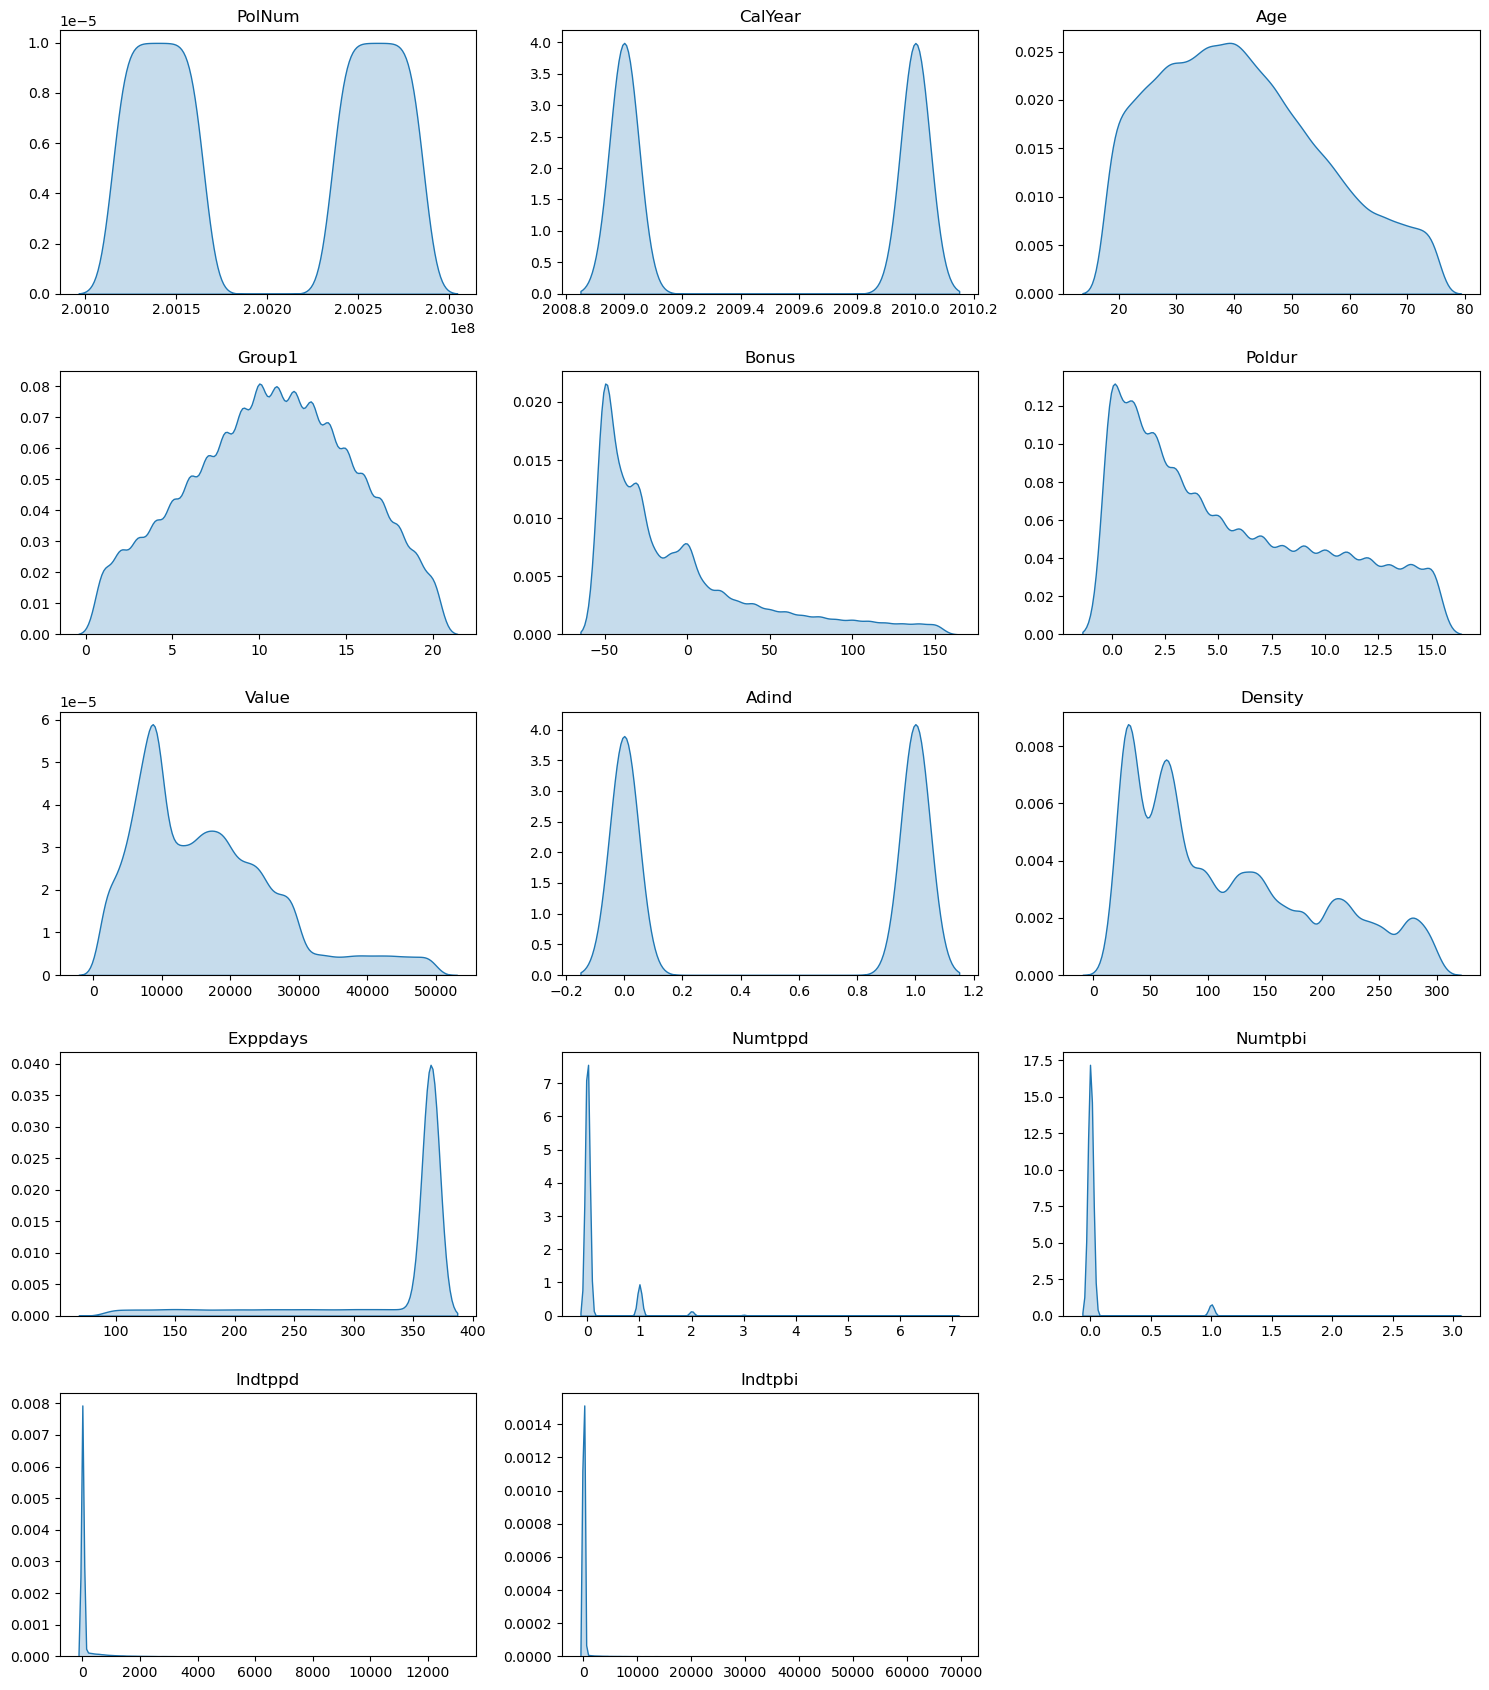

In [15]:
# Determine continuous variables
numerical_vars = training_data.select_dtypes(include=[np.number]).columns.tolist()

# Plot KDE plots for continuous variables
plt.figure(figsize=(15, 17))
for c, var in enumerate(numerical_vars):
    plt.subplot(5, 3, c+1)
    sns.kdeplot(data=training_data, x=var, fill=True)
    plt.title(str(var))
    plt.xlabel("")
    plt.ylabel("")

plt.tight_layout()
plt.show()


Interpretations : 

PolNum: Have a bimodal distribution with two distinct peaks. This could indicate two different groups within the dataset (which are the groups in 2009 and 2010).

CalYear: This distribution is also bimodal, which might suggest two different periods in which data was collect (which are the years 2009 and 2010t.

Age: Shows a distribution that at skewed to tleftght, indicating a younger population, with fewer older individ (between 30 and 50 years old approls.

Group1: The distribution is roughlyngularhaped, possibly indicating a uniform distribution across the range, with a peak a centerthe  (peak corresponds to the group of cars for which we have the highest number of contr.tory)

Bonus: This plot shleft right skew, indicating that bonuses are tyynts) y (discounts) lower with a few larger bonuses bein g lesscommon.

Poldur: lefher right-skewed distribution, implying that shorter policy durations are more commonn than loger ones.

Value: Exhibileftlong right tail, indicating a concentration of lower values with some highaer values s outliers.
Highly skewed to the right, suggesting that most of the expected days are very low with a few extreme values.reme values.

Adind: This variable has a bimodal distribution with two peaks at the extremes and a lower density in the middle, which might suggest two dior behaviors in the data.s in the daShows several peaks and a left skew, which could imply multiple modes of density within the dataset.hthin the dataset.

Numtppd: Another highly skewed distribution with most of the data lowest values (at the beginning)rated at the low end.
 high p: Shows a verwest values at the beginningep peak at the low end, indicating that most values are near zero, with a long tail suggesting outliers.

Indtpd: Shows a concentration of values near zero, with a s Shows a very high peak at the lowest values at the beginning, indicating that most values are near zero, with a long tail suggesting outliers.centration at the low end.low end.ration at the low end.

# Handling outliers
# Define the list of numerical columns
numerical_cols = ['Indtppd', 'Indtpbi']  

# Iterate over each numerical column
for col in numerical_cols:
    # Calculate the IQR
    Q1 = training_data[col].quantile(0.05)
    Q3 = training_data[col].quantile(0.95)
    IQR = Q3 - Q1

    # Define the bounds for the outliers
    lower_bound = Q1 - 0.5 * IQR
    upper_bound = Q3 + 0.5 * IQR

    # Cap the outliers
    training_data[col + '_Capped'] = training_data[col].apply(lambda x: min(max(x, lower_bound), upper_bound))

In [16]:
# Handling outliers based on standard deviations

# Define the list of numerical columns
cols_with_outliers = ['Indtpbi', 'Indtppd', 'Bonus']

# Iterate over each numerical column
for col in cols_with_outliers:
    # Calculate mean, standard deviation, and threshold
    mean = np.mean(training_data[col])
    std = np.std(training_data[col])
    threshold = 3  # I chose 3 as the number of standard deviations to use as threshold
    
    # Find outliers
    outliers = training_data[col][np.abs(training_data[col] - mean) > threshold * std]
    
    # Create a new column with processed values (replacing outliers with NaN)
    processed_col_name = col + '_processed'
    training_data[processed_col_name] = training_data[col].where(~training_data[col].isin(outliers))


In [17]:
# Replace null values with median
training_data['Indtpbi_processed'].fillna(training_data['Indtpbi_processed'].median(), inplace=True)
training_data['Indtppd_processed'].fillna(training_data['Indtppd_processed'].median(), inplace=True)
training_data['Bonus_processed'].fillna(training_data['Bonus_processed'].median(), inplace=True)

In [18]:
# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data.describe()


Summary Statistics of Training Dataset:


PolNum        CalYear            Age         Group1  \
count  1.000210e+05  100021.000000  100021.000000  100021.000000   
mean   2.002003e+08    2009.499895      41.122514      10.692625   
std    6.217239e+04       0.500002      14.299349       4.687286   
min    2.001149e+08    2009.000000      18.000000       1.000000   
25%    2.001399e+08    2009.000000      30.000000       7.000000   
50%    2.001649e+08    2009.000000      40.000000      11.000000   
75%    2.002608e+08    2010.000000      51.000000      14.000000   
max    2.002858e+08    2010.000000      75.000000      20.000000   

               Bonus         Poldur          Value          Adind  \
count  100021.000000  100021.000000  100021.000000  100021.000000   
mean       -6.921646       5.470781   16454.675268       0.512142   
std        48.633165       4.591194   10506.742732       0.499855   
min       -50.000000       0.000000    1000.000000       0.000000   
25%       -40.000000       1.000000    8380.000000       0.000000   
50%       -30.000000       4.000000   14610.000000       1.000000   
75%        10.000000       9.000000   22575.000000       1.000000   
max       150.000000      15.000000   49995.000000       1.000000   

             Density       Exppdays        Numtppd        Numtpbi  \
count  100021.000000  100021.000000  100021.000000  100021.000000   
mean      117.159270     327.588007       0.147449       0.046790   
std        79.500907      73.564636       0.436917       0.219546   
min        14.377142      91.000000       0.000000       0.000000   
25%        50.625783     340.000000       0.000000       0.000000   
50%        94.364623     365.000000       0.000000       0.000000   
75%       174.644525     365.000000       0.000000       0.000000   
max       297.385170     365.000000       7.000000       3.000000   

             Indtppd        Indtpbi  Indtpbi_processed  Indtppd_processed  \
count  100021.000000  100021.000000      100021.000000      100021.000000   
mean      106.135007     222.762829          53.431082          50.582517   
std       444.949188    1859.422836         409.267436         193.913012   
min         0.000000       0.000000           0.000000           0.000000   
25%         0.000000       0.000000           0.000000           0.000000   
50%         0.000000       0.000000           0.000000           0.000000   
75%         0.000000       0.000000           0.000000           0.000000   
max     12878.369910   69068.026292        5796.313276        1440.666933   

       Bonus_processed  
count    100021.000000  
mean        -10.143570  
std          44.038319  
min         -50.000000  
25%         -40.000000  
50%         -30.000000  
75%          10.000000  
max         130.000000

In [19]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [   0.          740.30229036  207.32365675 ...  546.40798246  822.92046036
 5800.0189068 ]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 90  30 150   0  40  80 -20 -40 120 -30  20  50 -50 -10 100  10 110 140
  70  60 130]


In [20]:
print("Valeurs uniques de la colonne Numtppd:", training_data['Numtppd'].unique())
print("Valeurs uniques de la colonne Numtpbi:", training_data['Numtpbi'].unique())
print("Valeurs uniques de la colonne Indtppd:", training_data['Indtppd_processed'].unique())
print("Valeurs uniques de la colonne Indtpbi:", training_data['Indtpbi_processed'].unique())
print("Valeurs uniques de la colonne Bonus:", training_data['Bonus_processed'].unique())

Valeurs uniques de la colonne Numtppd: [1 2 0 3 4 5 6 7]
Valeurs uniques de la colonne Numtpbi: [0 1 2 3]
Valeurs uniques de la colonne Indtppd: [  0.         740.30229036 207.32365675 ... 965.69781692 546.40798246
 822.92046036]
Valeurs uniques de la colonne Indtpbi: [0.00000000e+00 3.84004453e+03 2.79371442e+03 ... 3.52825919e+00
 1.05603349e+03 1.65076419e+01]
Valeurs uniques de la colonne Bonus: [ 90.  30. -30.   0.  40.  80. -20. -40. 120.  20.  50. -50. -10. 100.
  10. 110.  70.  60. 130.]


In [21]:
# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])  # Select only numeric columns

# Calculer le 90e percentile pour chaque colonne numérique
percentile_90 = numeric_cols.quantile(0.9)

# Compter le nombre de valeurs au-dessus du 90e percentile dans chaque colonne
count_above_90 = (numeric_cols > percentile_90).sum()

# Calculer le pourcentage des valeurs au-dessus du 90e percentile dans chaque colonne
percentage_above_90 = (count_above_90 / len(numeric_cols)) * 100

# Afficher les pourcentages
print("Pourcentage des valeurs au-dessus du 90e percentile dans chaque colonne :")
print(percentage_above_90)

Pourcentage des valeurs au-dessus du 90e percentile dans chaque colonne :
PolNum               9.999900
CalYear              0.000000
Age                  9.530998
Group1               7.824357
Bonus                8.996111
Poldur               7.149499
Value                9.991902
Adind                0.000000
Density              9.701963
Exppdays             0.000000
Numtppd              1.918597
Numtpbi              4.505054
Indtppd              9.999900
Indtpbi              4.505054
Indtpbi_processed    3.283311
Indtppd_processed    9.999900
Bonus_processed      8.764160
dtype: float64


#Second method : replacing by the median value : 

# Select only numeric columns
numeric_cols = training_data.select_dtypes(include=['number'])  # Select only numeric columns

# Outlier detection using IQR
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 0.5 * IQR
upper_bound = Q3 + 0.5 * IQR

# Identify outliers
outliers = (numeric_cols < lower_bound) | (numeric_cols > upper_bound)

# Handling outliers: Replace outliers with the median value
training_data_no_outliers = numeric_cols.mask(outliers, numeric_cols.median(), axis=0)

# Fill remaining NaN values with median column-wise
training_data_no_outliers = training_data_no_outliers.fillna(training_data_no_outliers.median())

# Summary statistics of the training dataset
print("\nSummary Statistics of Training Dataset:")
training_data_no_outliers.describe()

#### Analysis of categorical variables

In [22]:
# Select categorical variables
categorical_var = training_data.select_dtypes(include=["object"]).columns.to_list()
# Number of unique values per variable
training_data[categorical_var].nunique()

Gender          2
Type            6
Category        3
Occupation      5
SubGroup2     471
Group2         10
dtype: int64

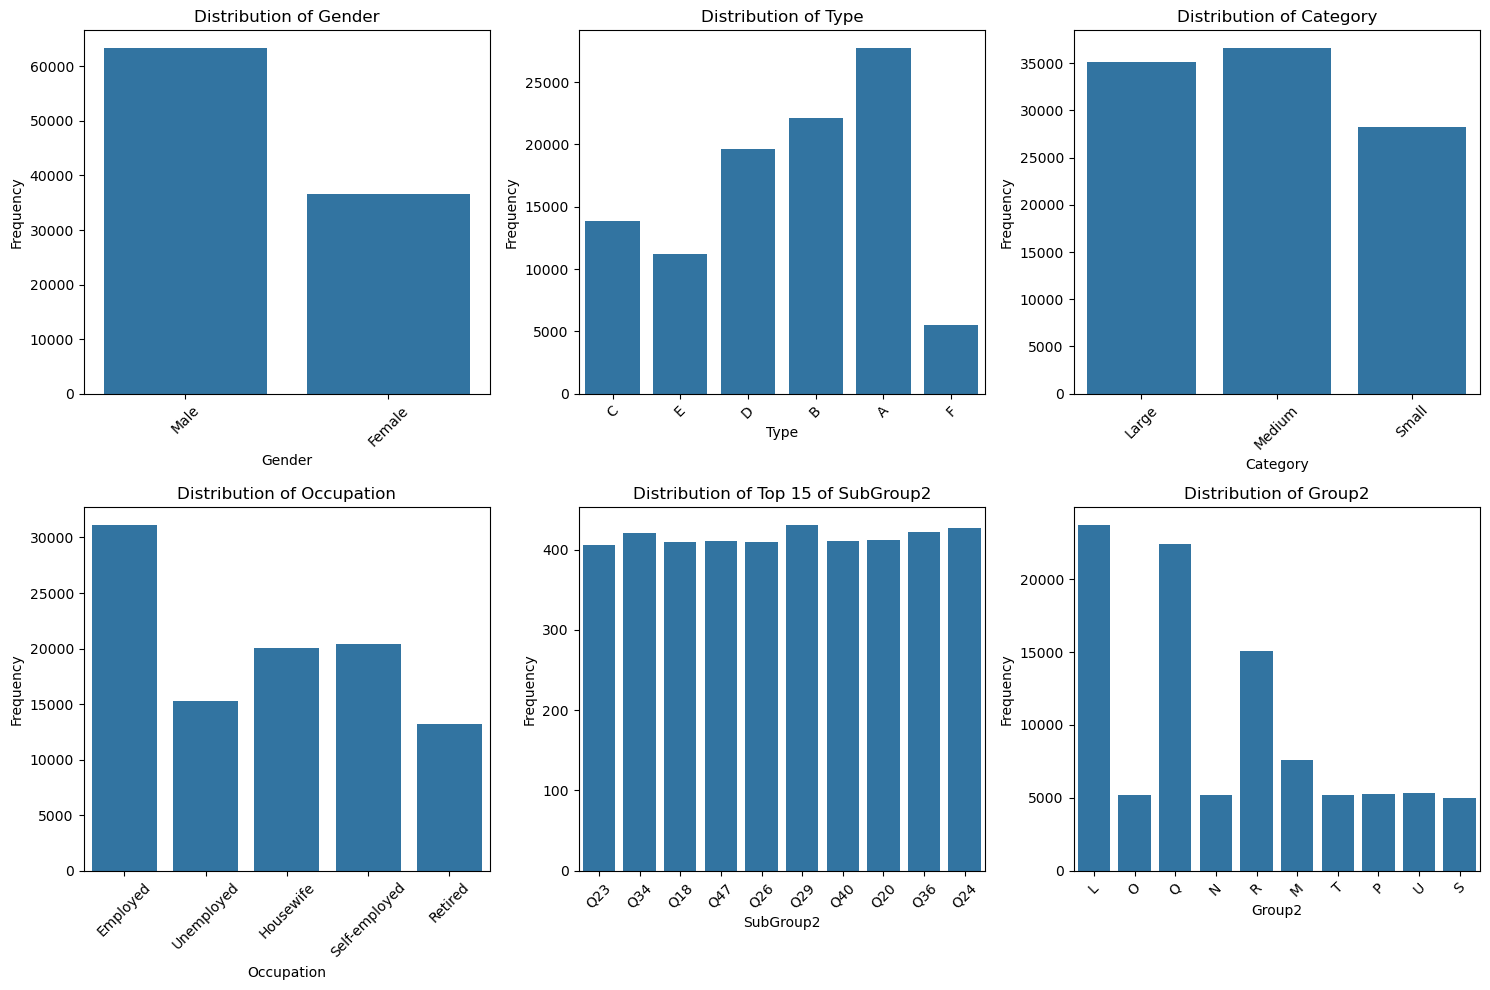

In [23]:
# Univariate analysis for categorical variables
categorical_vars = training_data.select_dtypes(include=['object']).columns

# Calculate the number of rows and columns for the layout
num_cols = 3  # Number of columns per row
num_rows = (len(categorical_vars) - 1) // num_cols + 1  # Number of rows

# Plot categorical variables using count plots
plt.figure(figsize=(15, 10))
for i, var in enumerate(categorical_vars):
    if var == 'SubGroup2':
        top_categories = training_data[var].value_counts().nlargest(10).index
        data_subset = training_data[training_data[var].isin(top_categories)]
        title = f'Distribution of Top 15 of {var}'
    else:
        data_subset = training_data
        title = f'Distribution of {var}'
    plt.subplot(num_rows, num_cols, i+1)
    sns.countplot(x=var, data=data_subset)
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

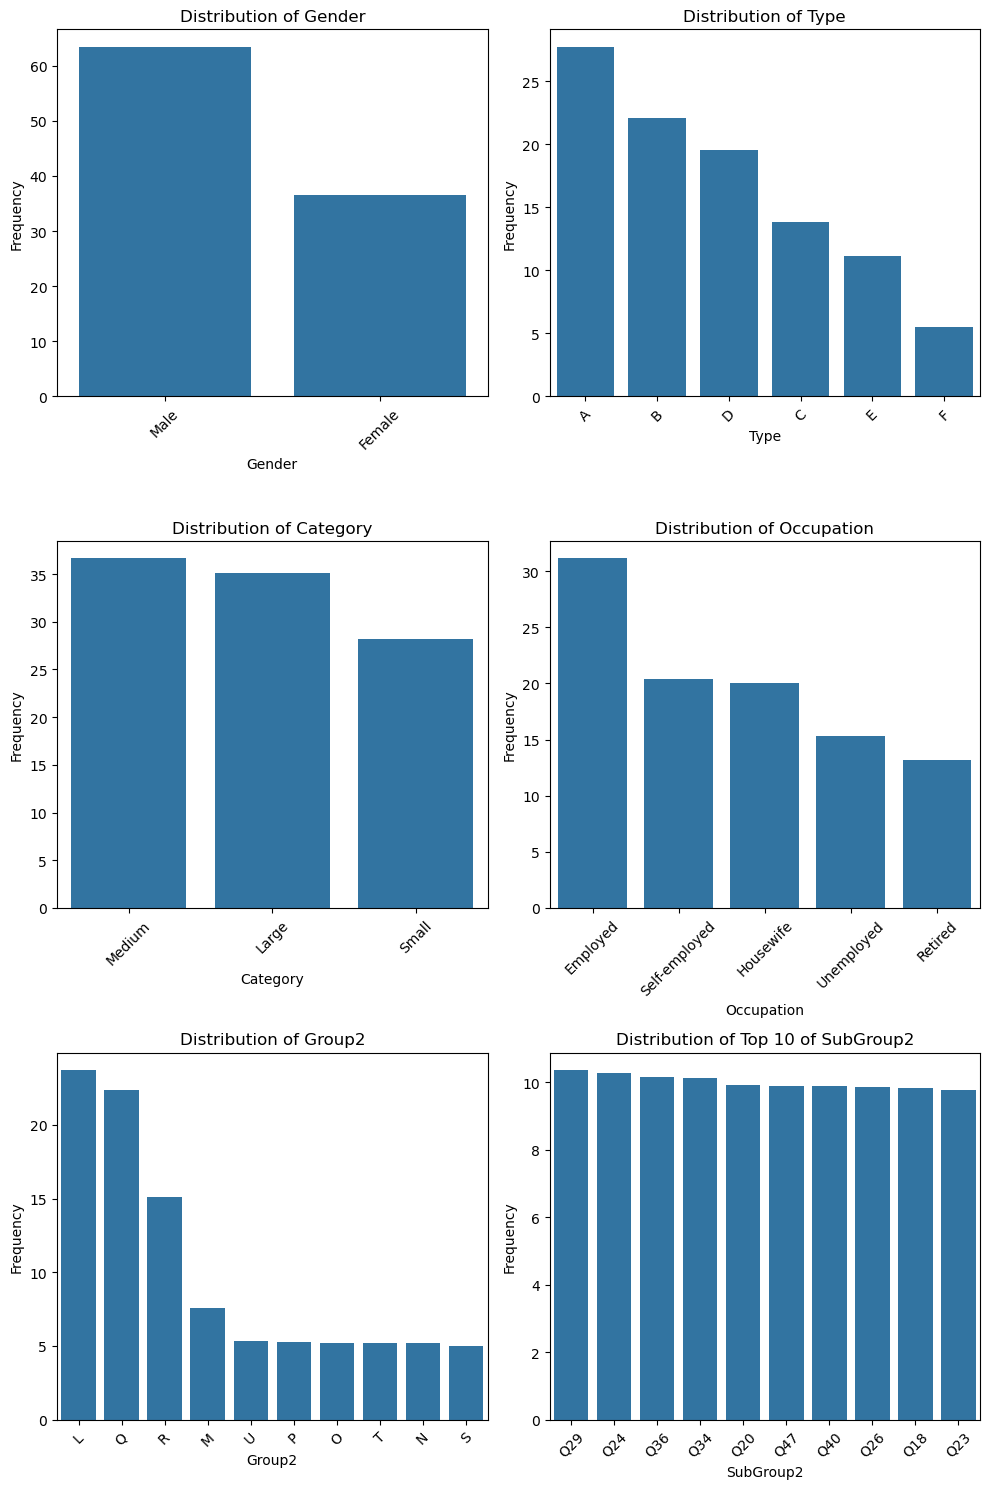

In [24]:
# Select categorical variables with a small number of unique values
df_barplot = training_data[["Gender", "Type", "Category", "Occupation", "Group2", "SubGroup2"]]

# Create barplot with frequency for each variable
plt.figure(figsize=(10, 15))

for c, var in enumerate(df_barplot.columns):
    if var == 'SubGroup2':
        top_categories = training_data[var].value_counts().nlargest(10).index
        data_subset = training_data[training_data[var].isin(top_categories)]
        title = f'Distribution of Top 10 of {var}'
    else:
        data_subset = training_data
        title = f'Distribution of {var}'

    # Compute frequency of each unique value
    df = data_subset[var].value_counts(normalize=True).to_frame("frequency").reset_index()
    df["frequency"] *= 100

    # Plot the barplot
    plt.subplot(3, 2, c+1)
    sns.barplot(data=df, x=var, y="frequency")
    plt.title(title)
    plt.xlabel(var)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [25]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100021 entries, 1 to 100021
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   PolNum             100021 non-null  int64  
 1   CalYear            100021 non-null  int64  
 2   Gender             100021 non-null  object 
 3   Type               100021 non-null  object 
 4   Category           100021 non-null  object 
 5   Occupation         100021 non-null  object 
 6   Age                100021 non-null  int64  
 7   Group1             100021 non-null  int64  
 8   Bonus              100021 non-null  int64  
 9   Poldur             100021 non-null  int64  
 10  Value              100021 non-null  int64  
 11  Adind              100021 non-null  int64  
 12  SubGroup2          100021 non-null  object 
 13  Group2             100021 non-null  object 
 14  Density            100021 non-null  float64
 15  Exppdays           100021 non-null  int64  
 16  Numtppd

In [26]:
# Get general information on the dataset (ncol, nrow, nbr missing values, dtypes)
training_data.isnull().sum()

PolNum               0
CalYear              0
Gender               0
Type                 0
Category             0
Occupation           0
Age                  0
Group1               0
Bonus                0
Poldur               0
Value                0
Adind                0
SubGroup2            0
Group2               0
Density              0
Exppdays             0
Numtppd              0
Numtpbi              0
Indtppd              0
Indtpbi              0
Indtpbi_processed    0
Indtppd_processed    0
Bonus_processed      0
dtype: int64

##### **2. Multivariate Data Analysis**

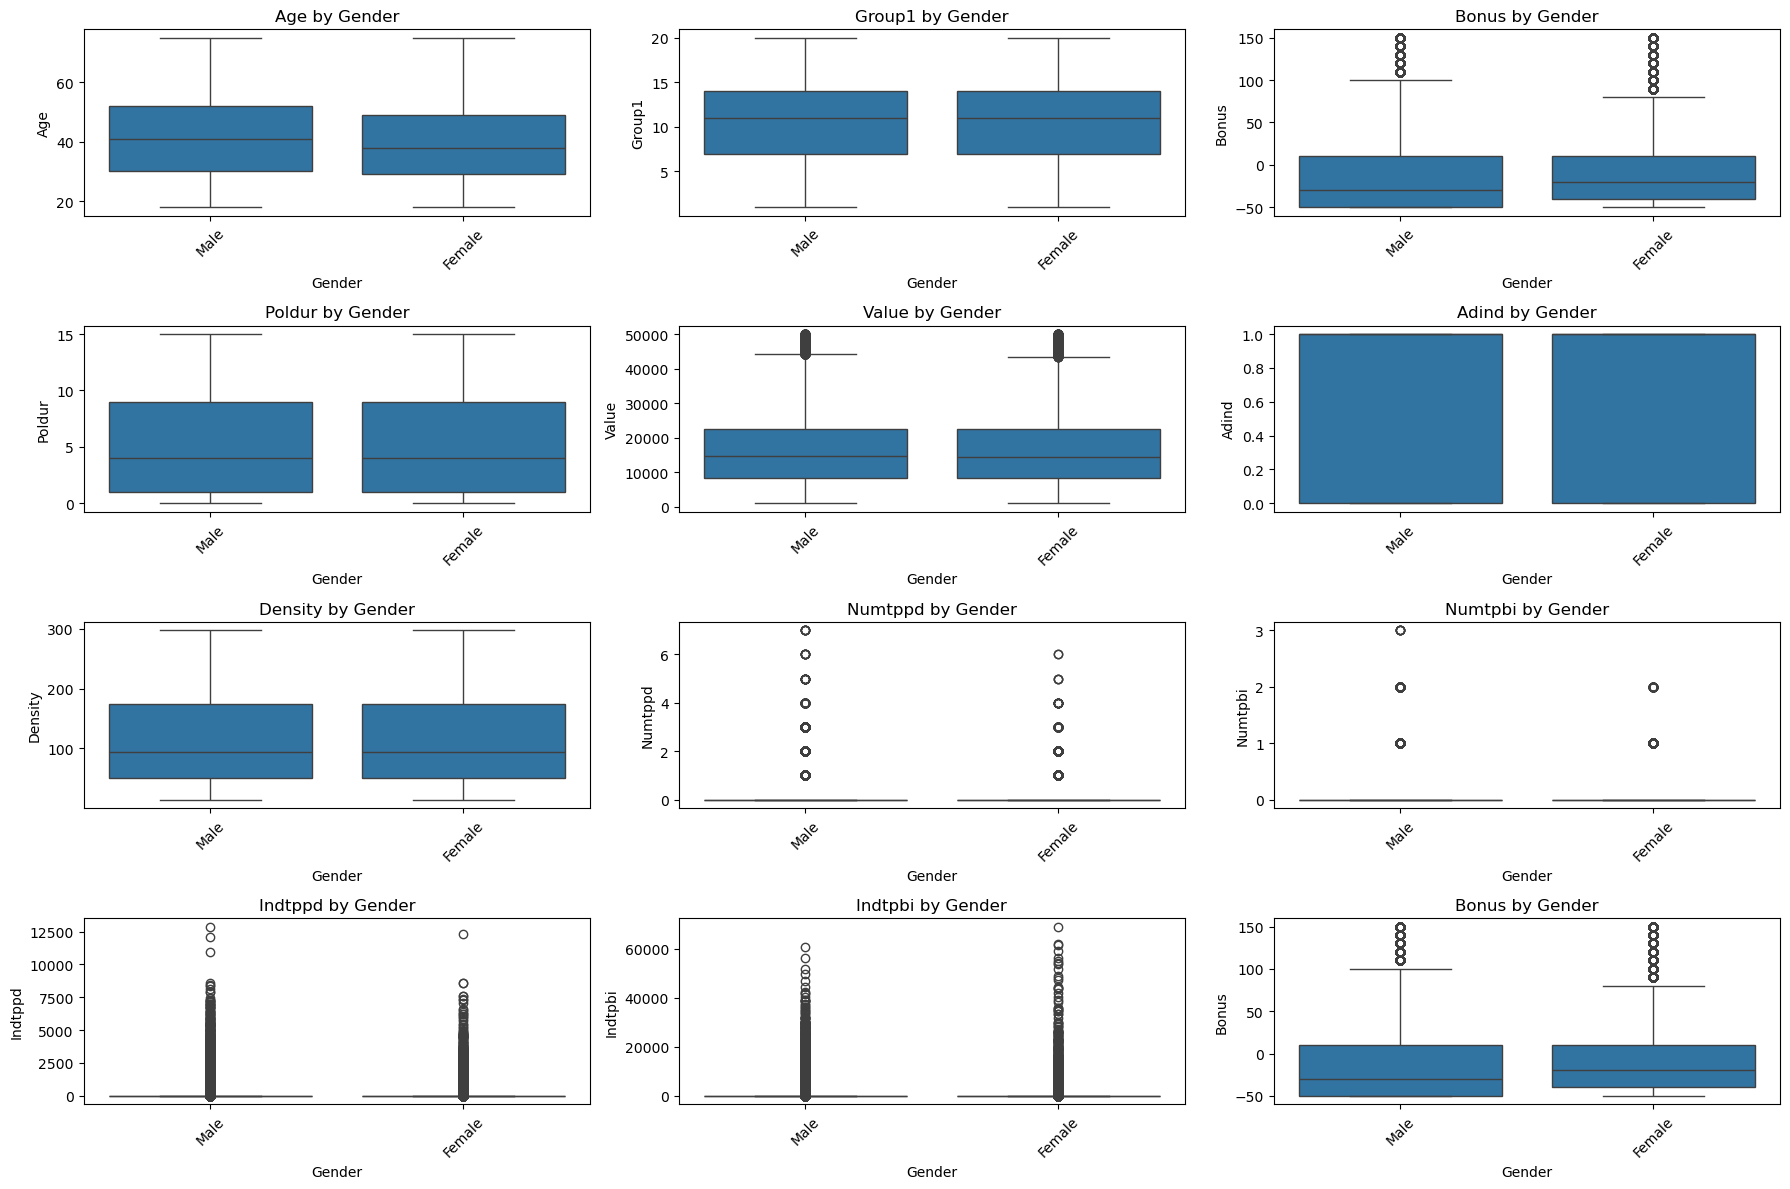

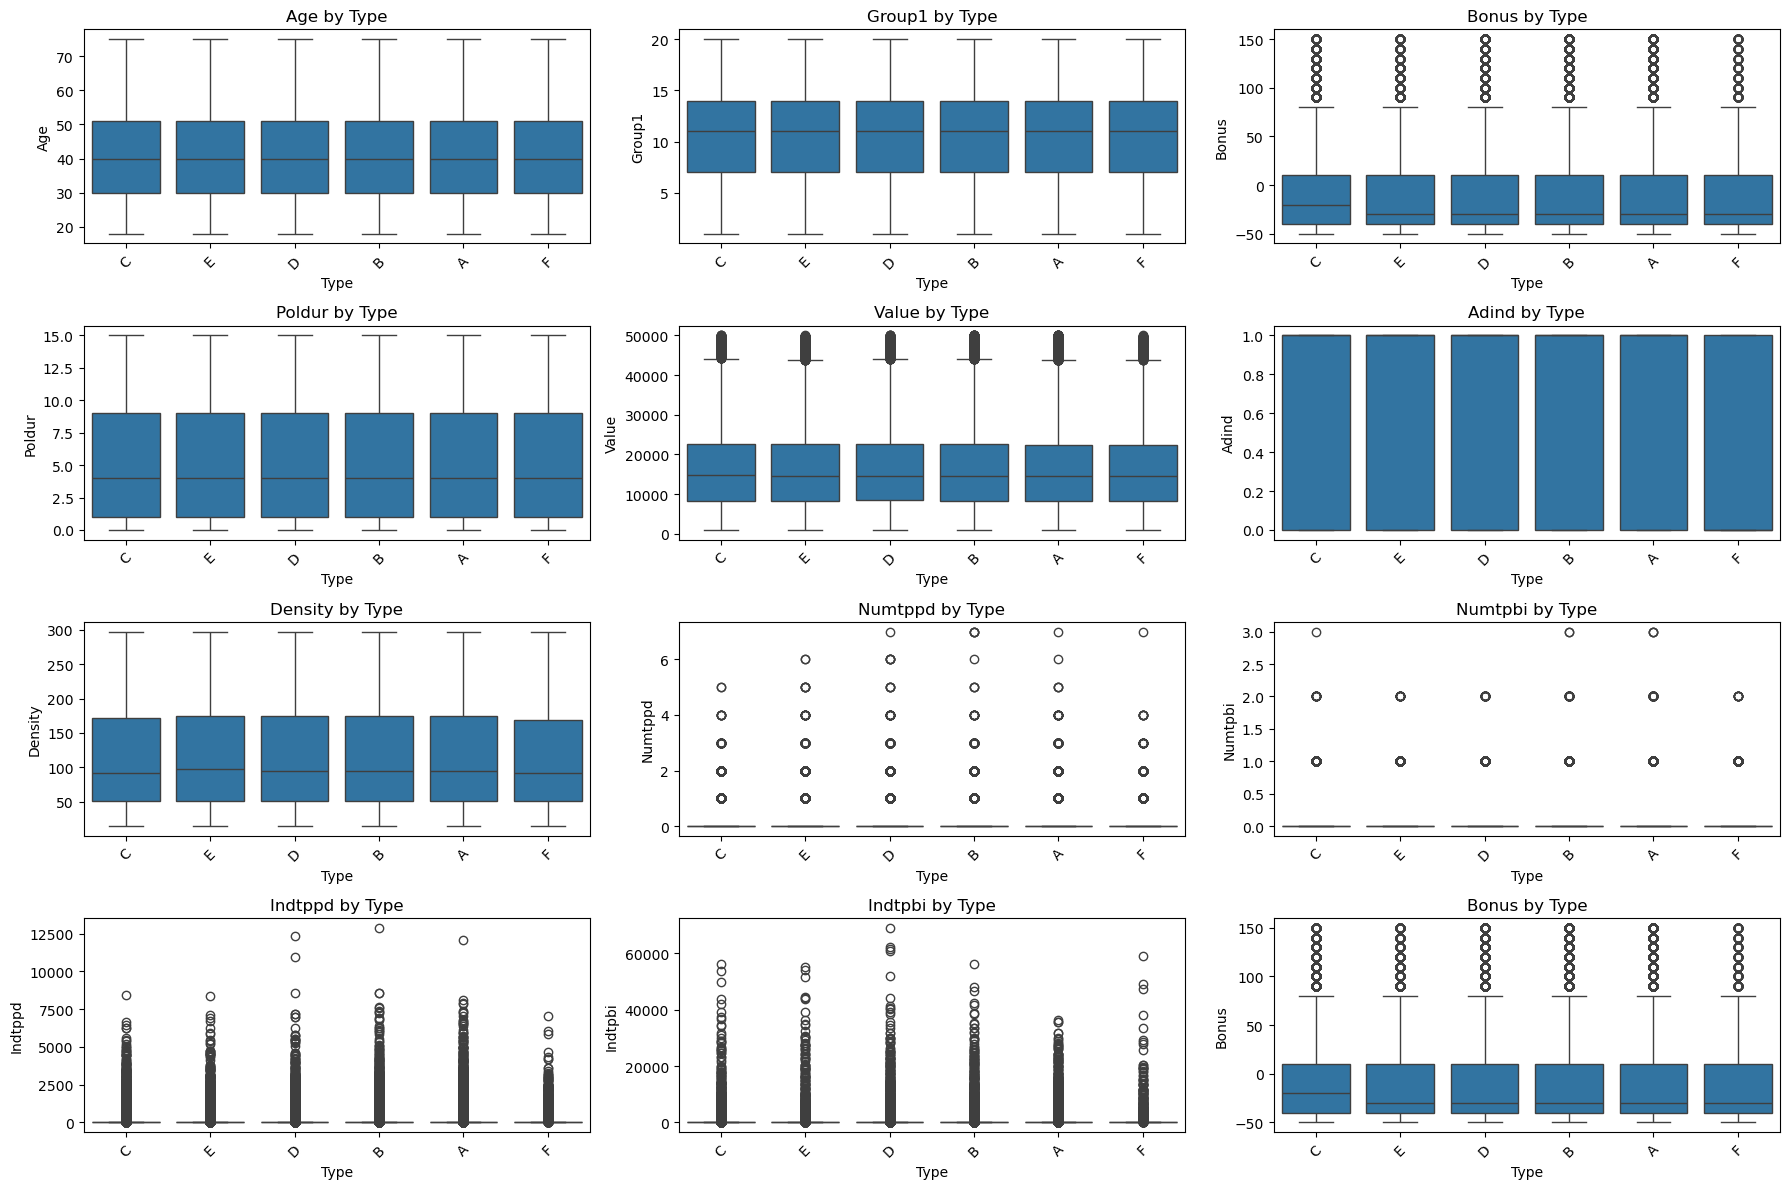

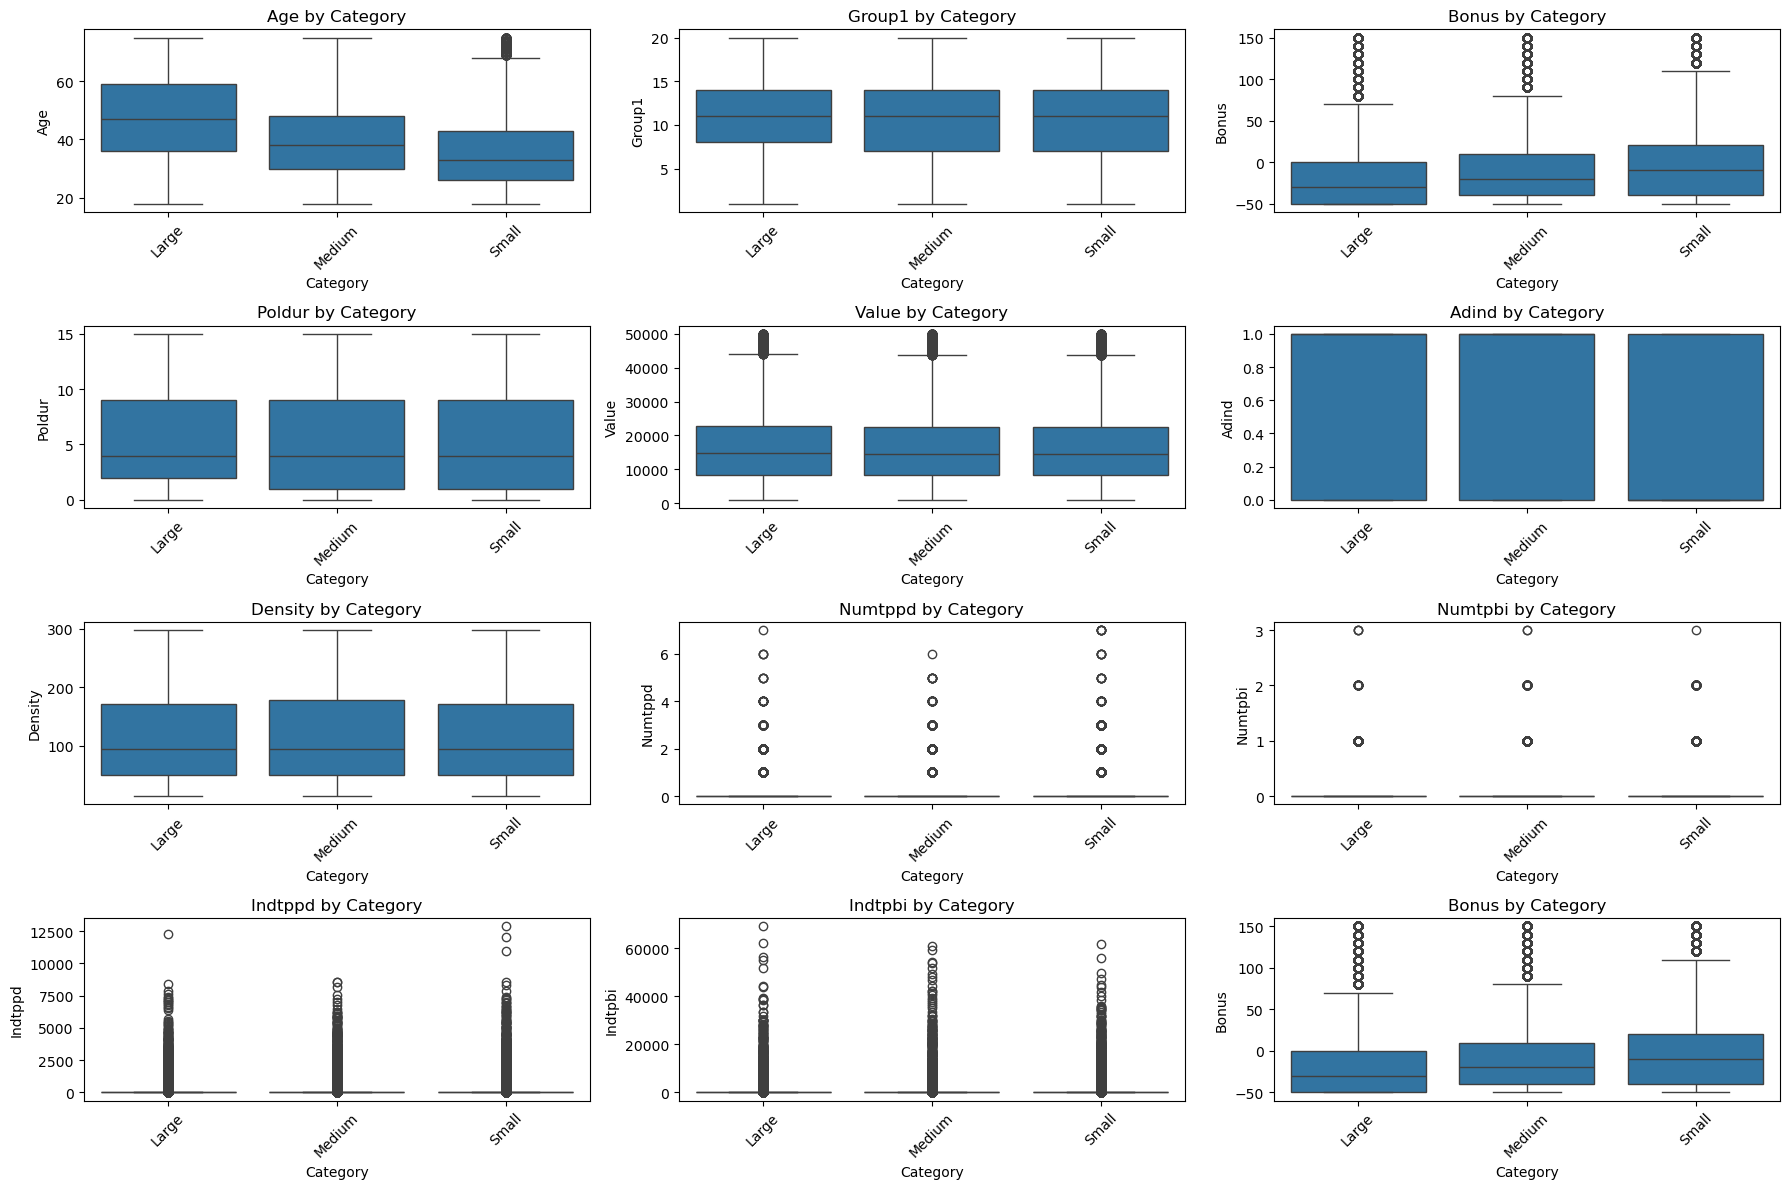

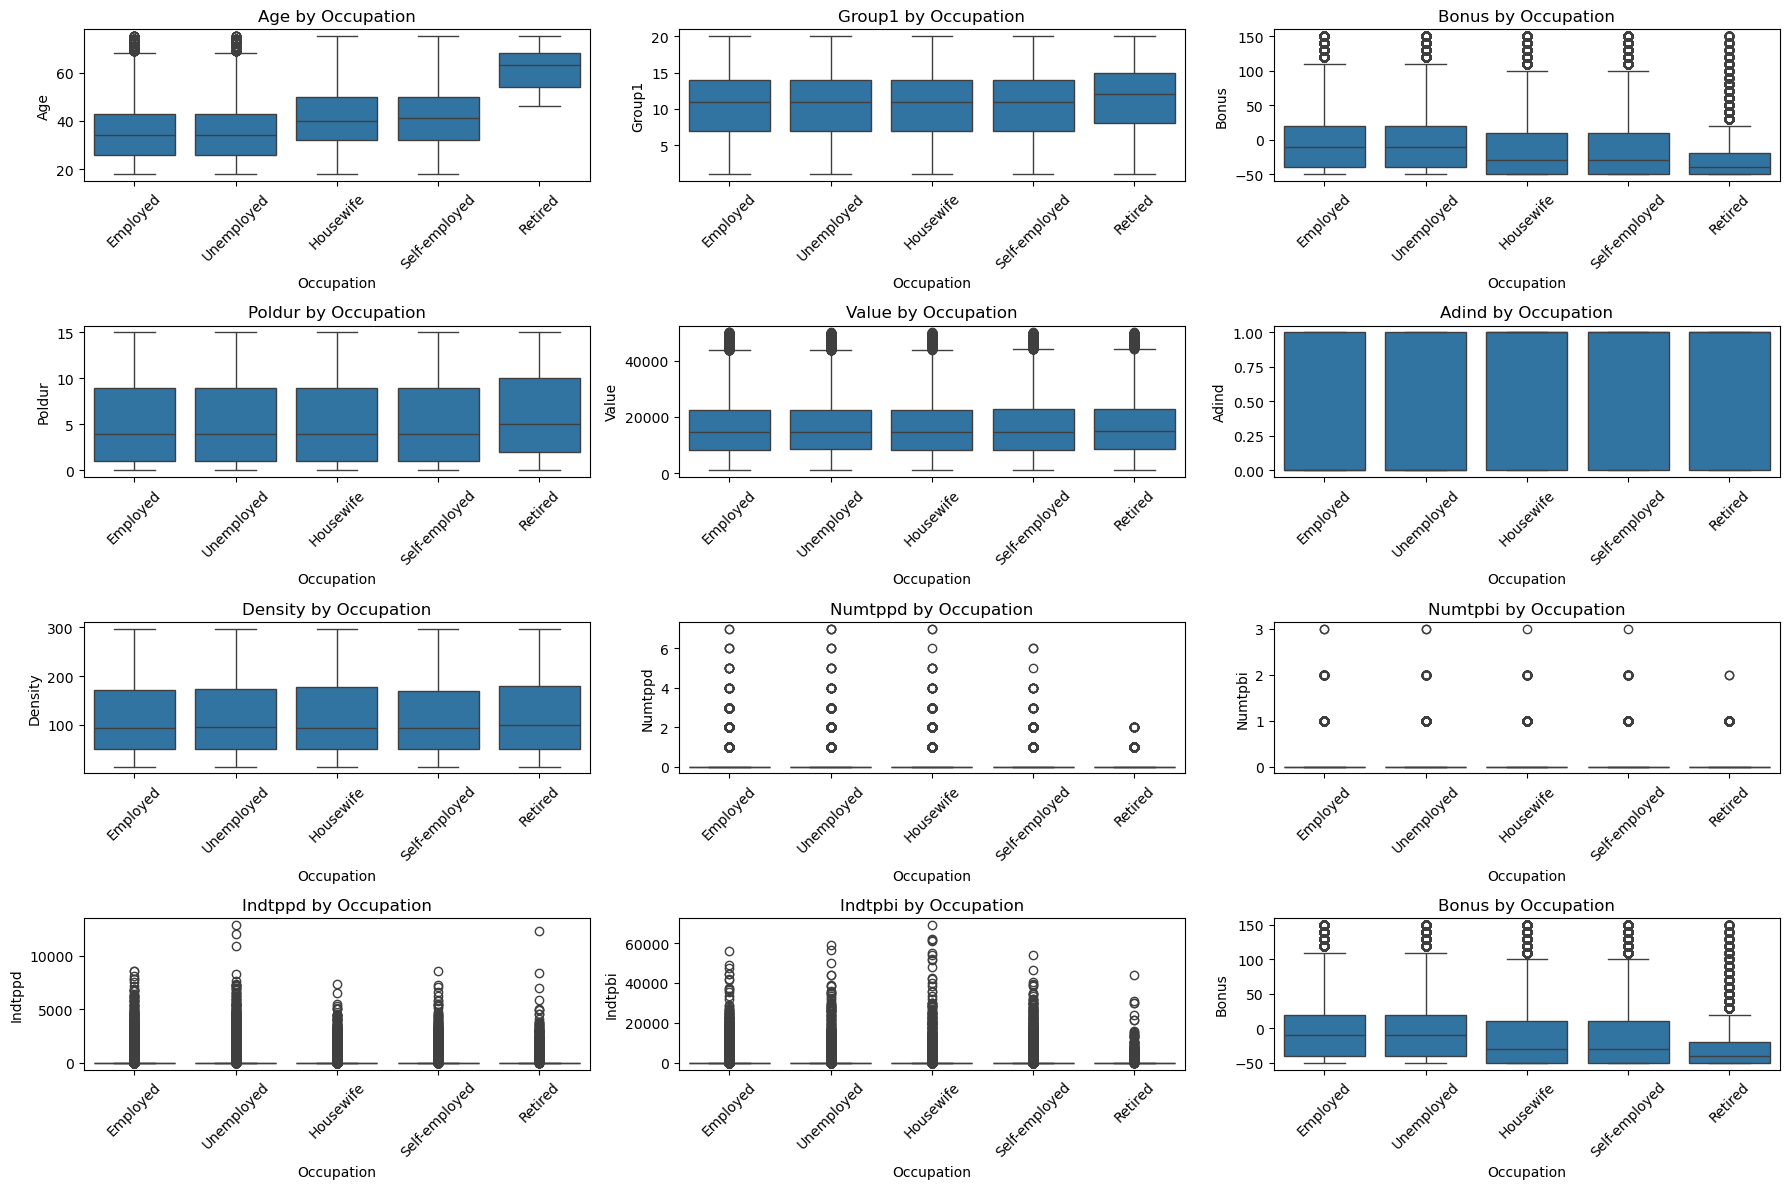

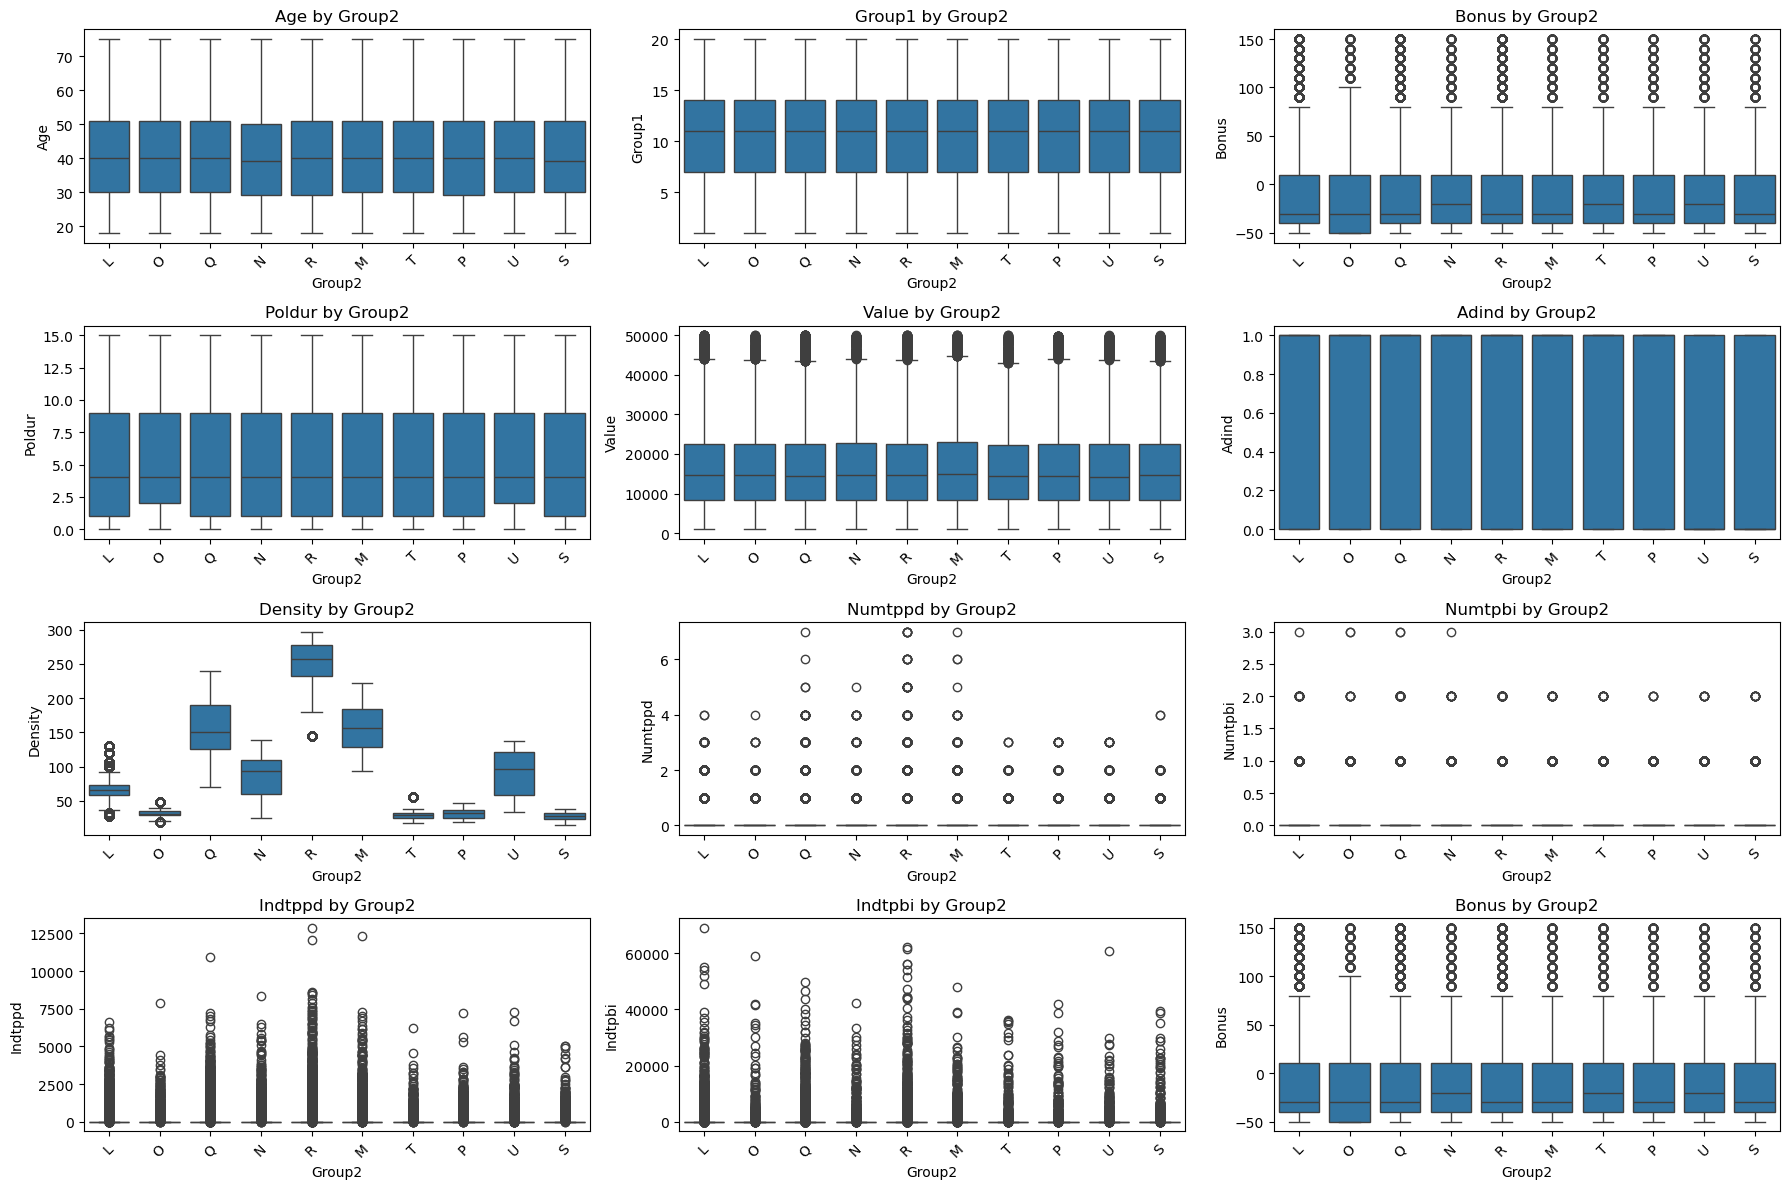

In [27]:
#Categorical and Continuous
# Select continuous variables
continuous_vars = ['Age', 'Group1', 'Bonus', 'Poldur', 'Value', 'Adind', 'Density', 'Numtppd', 'Numtpbi',
                   'Indtppd', 'Indtpbi', 'Bonus']

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']

# Calculate the number of rows and columns needed for the layout
num_cols = 3  
num_rows = (len(continuous_vars) - 1) // num_cols + 1  

# Visualize the relationship between each continuous variable and each categorical variable
for cat_var in categorical_vars:
    plt.figure(figsize=(18, 12))
    for i, cont_var in enumerate(continuous_vars, 1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(x=cat_var, y=cont_var, data=training_data)
        plt.title(f'{cont_var} by {cat_var}')
        plt.xlabel(cat_var)
        plt.ylabel(cont_var)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


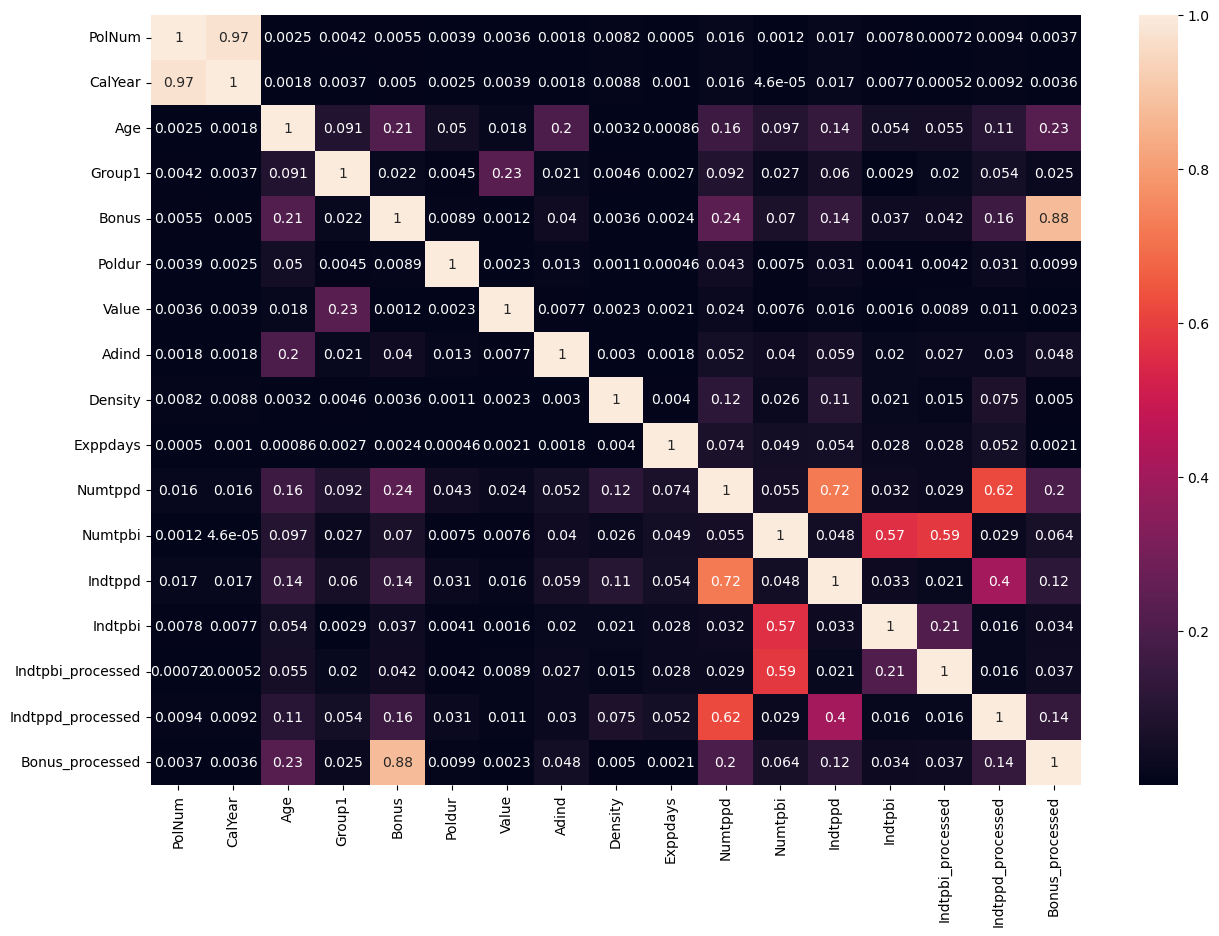

In [28]:
#Continuous and continuous 
numeric_cols = training_data.select_dtypes(include=['number'])  # Select only numeric columns
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_cols.corr().abs(), annot=True)
plt.show()


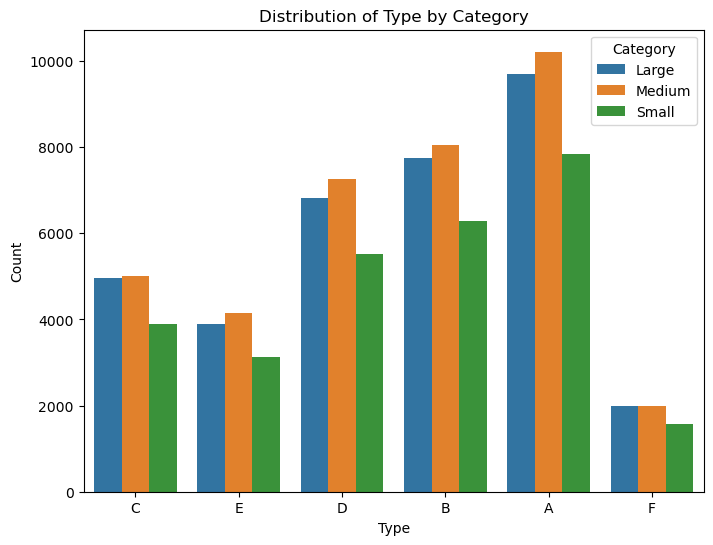

In [29]:
#categorical VS categorical 
plt.figure(figsize=(8, 6))
sns.countplot(x='Type', hue='Category', data=training_data)
plt.title('Distribution of Type by Category')
plt.xlabel('Type')
plt.ylabel('Count')
plt.legend(title='Category')
plt.show()

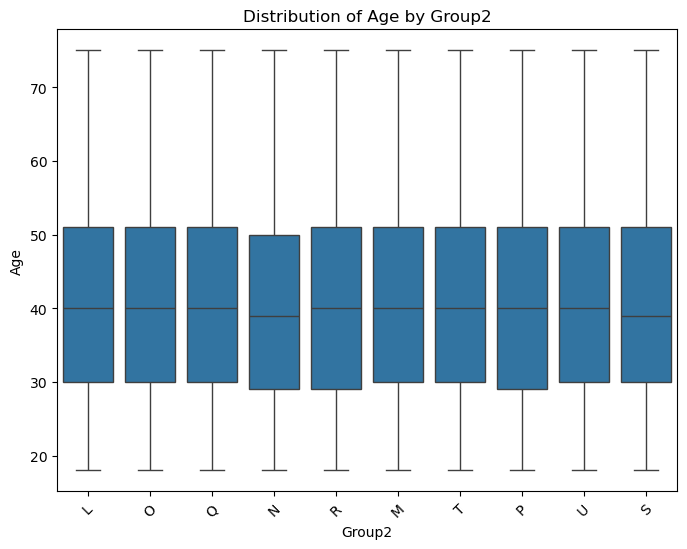

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Group2', y='Age', data=training_data)
plt.title('Distribution of Age by Group2')
plt.xlabel('Group2') #groupe 2 represents the drivers'home region
plt.ylabel('Age')
plt.xticks(rotation=45)
plt.show()

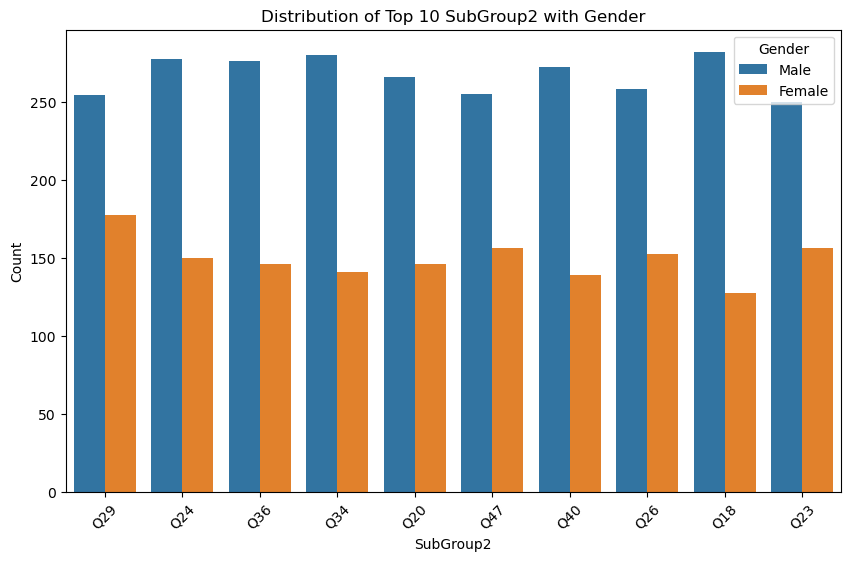

In [31]:
# Get the top 10 categories in 'SubGroup2'
top_subgroup2 = training_data['SubGroup2'].value_counts().nlargest(10).index #recall : SubGroup2: Driver's home sub-region.

# Filter the dataset for the top 10 categories
top_subgroup2_data = training_data[training_data['SubGroup2'].isin(top_subgroup2)] 

# Create the count plot with hue as 'Gender'
plt.figure(figsize=(10, 6))
sns.countplot(x='SubGroup2', hue='Gender', data=top_subgroup2_data, order=top_subgroup2)
plt.title('Distribution of Top 10 SubGroup2 with Gender')
plt.xlabel('SubGroup2')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()


In [32]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Indtppd'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Indtppd: p-value = 0.9999852228504844
Cramer's V for Gender and Indtppd: 0.34074257654356815
Chi-squared test result for Type and Indtppd: p-value = 1.9657530484875496e-22
Cramer's V for Type and Indtppd: 0.8044546021484624
Chi-squared test result for Category and Indtppd: p-value = 0.009206160555246697
Cramer's V for Category and Indtppd: 0.5003168995056578
Chi-squared test result for Occupation and Indtppd: p-value = 1.0
Cramer's V for Occupation and Indtppd: 0.6805705763894605
Chi-squared test result for Group2 and Indtppd: p-value = 1.0
Cramer's V for Group2 and Indtppd: 1.018671761882254


The p-value resulting from the Chi-squared test indicates the statistical significance of the relationship between the target variable and each categorical variable.
And the Cramer's V is as well a statistical measure used to assess the association between categorical variables. Cramer's V ranges from 0 to 1, where 0 indicates no association and 1 indicates a perfect association. It  provides a standardized measure of the strength of association, allowing for easier interpretation and comparison across different studies or datasets.
NB : Group 2 have a strong relationship and at the same time have a high p value which means that the variables can be independent ! 

In [33]:
#Analysis of the categorical variables vs potential target variables : 

# Select categorical variables
categorical_vars = ['Gender', 'Type', 'Category', 'Occupation', 'Group2']
target_variable = 'Indtpbi'

# Loop through categorical variables
for var in categorical_vars:
    # Chi-squared test
    table = pd.crosstab(training_data[target_variable], training_data[var])
    chi2_stat, p_value, _, _ = scipy.stats.chi2_contingency(table)
    print(f"Chi-squared test result for {var} and {target_variable}: p-value = {p_value}")
    
    # Cramer's V calculation
    cramer_v = np.sqrt(chi2_stat / len(training_data))
    print(f"Cramer's V for {var} and {target_variable}: {cramer_v}")

Chi-squared test result for Gender and Indtpbi: p-value = 0.8934007138622158
Cramer's V for Gender and Indtpbi: 0.20941124866173572
Chi-squared test result for Type and Indtpbi: p-value = 0.44802267811822194
Cramer's V for Type and Indtpbi: 0.47478773727715157
Chi-squared test result for Category and Indtpbi: p-value = 0.04073179482604187
Cramer's V for Category and Indtpbi: 0.30399445159088456
Chi-squared test result for Occupation and Indtpbi: p-value = 0.9999999011104369
Cramer's V for Occupation and Indtpbi: 0.4128243203114816
Chi-squared test result for Group2 and Indtpbi: p-value = 0.9951087065940399
Cramer's V for Group2 and Indtpbi: 0.6308394778142368


For the categorical variables, we will need all our variables which are : 
Gender
Type
Category
Occupation
  
Except the variables group 2 and subGroup2, as the information of the drivers' home region is irrelevant for the estimation of the premium value.As well the chi-2 test and Cramers's test reveals their irrelevance. 

For the numerical variables, we will need : (as the below variables may have an impact on premium costs.)
PolNum    
CalYear    
Age    Adind
Density 
Numtpbi_processed
Indtppd_processed
Numtppd_processed
Bonus
Exppdays

Target variable 
Indtpbi_processedMB


In [34]:
# Define the function to convert numeric to categorical variables
def convert_numeric_to_categorical(data):
    # Define custom categories
    custom_categories = {
        0: 'Category A',
        1: 'Category B',
        2: 'Category C',
        3: 'Category D',
        4: 'Category E',
        5: 'Category F',
        6: 'Category G',
        7: 'Category H'
    }
    # Create new categorical columns from the original numeric columns
    data['Numtppd_cat'] = data['Numtppd'].map(custom_categories)
    data['Numtpbi_cat'] = data['Numtpbi'].map(custom_categories)
    return data

# Apply the transformation function to your DataFrame
training_data = convert_numeric_to_categorical(training_data)

In [35]:
training_data_2 = training_data.copy()

In [53]:
training_data_2 = training_data_2.iloc[21:]

#### Step 3. Feature engineering (Data pre-processing)

In [123]:
# List of column names to select
columns_to_select = ['Group2', 'Category', 'PolNum', 'CalYear', 'Age', 'Adind', 'Density', 'Bonus', 'Exppdays',
                     'Numtpbi', 'Indtppd_processed', 'Numtppd']

# Select the columns and assign them to X
X = training_data[columns_to_select] # features
y = training_data["Indtpbi_processed"] # target variable

In [124]:
# Identification of missing values
X.isnull().sum()

Group2               0
Category             0
PolNum               0
CalYear              0
Age                  0
Adind                0
Density              0
Bonus                0
Exppdays             0
Numtpbi              0
Indtppd_processed    0
Numtppd              0
dtype: int64

In [125]:
# Applying a pipeline on categorical and numerical features
categorical_features = X.select_dtypes(include=['object', 'bool']).columns
numerical_features = X.select_dtypes(exclude=['object', 'bool']).columns

In [126]:

# Handling missing data and normalization of numeric data with Min Max Scaler
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # Replace missing numeric data by the median
    ("scaler", MinMaxScaler())])  # Normalization of numeric data after imputing for the missing values

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
#    ('onehot', OneHotEncoder(handle_unknown='ignore'))])  # Handling missing categorical data

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Not defined')),
    ('ordinal', OrdinalEncoder())])  # Ordinal encoding of categorical data


In [127]:
# Define the features preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [128]:
# As our target variable can be imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [129]:
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

#### Step 4. Applying the model

In [130]:
# Define and train the Random Forest regression model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Metrics:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R-squared Score: {r2_rf}")

Random Forest Regression Metrics:
Mean Squared Error: 123234.10260637684
Mean Absolute Error: 61.83819380707969
R-squared Score: 0.3278533691198723


In [131]:
# Define and train the XGBoost regression model
xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regression Metrics:")
print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Absolute Error: {mae_xgb}")
print(f"R-squared Score: {r2_xgb}")


XGBoost Regression Metrics:
Mean Squared Error: 136206.9030673626
Mean Absolute Error: 63.12139303550481
R-squared Score: 0.2570967851994036


In [132]:
# Define the Random Forest regressor
rf_model = RandomForestRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [1000, 2000, 3000],  # Number of trees in the forest
    'max_depth': [None, 5, 10],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at each leaf node
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_rf_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_rf = best_rf_model.predict(X_test)

# Evaluate the model
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regression Metrics:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R-squared Score: {r2_rf}")

Random Forest Regression Metrics:
Mean Squared Error: 115832.32587673921
Mean Absolute Error: 59.435920661065
R-squared Score: 0.36822433126534115


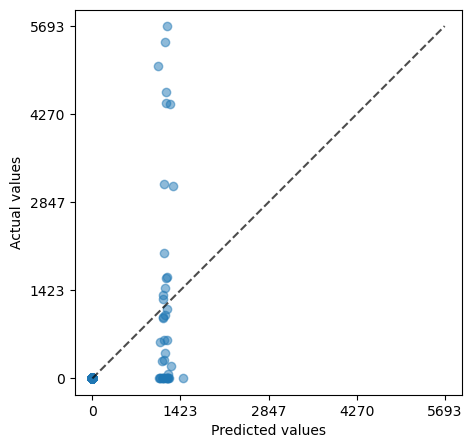

In [54]:
_, ax = plt.subplots(figsize=(5, 5))

display = PredictionErrorDisplay.from_predictions(y_test, y_pred_rf, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5})

In [73]:
# Define the XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'learning_rate': [0.05, 0.1, 0.2],  # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instance
    'colsample_bytree': [0.6, 0.8, 1.0]  # Subsample ratio of columns when constructing each tree
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regression Metrics:")
print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Absolute Error: {mae_xgb}")
print(f"R-squared Score: {r2_xgb}")


XGBoost Regression Metrics:
Mean Squared Error: 113466.25319922603
Mean Absolute Error: 60.77067483494159
R-squared Score: 0.3630074922690727


In [81]:
# Define the XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [700, 800, 900],  # Number of boosting rounds
    'max_depth': [2, 4, 6],  # Maximum depth of a tree
    'learning_rate': [0.05, 0.1, 0.15],  # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.1, 0.2, 0.3],  # Subsample ratio of the training instance
    'colsample_bytree': [0.1, 0.2, 0.3]  # Subsample ratio of columns when constructing each tree
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regression Metrics:")
print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Absolute Error: {mae_xgb}")
print(f"R-squared Score: {r2_xgb}")


XGBoost Regression Metrics:
Mean Squared Error: 112670.7809343922
Mean Absolute Error: 66.40096051714806
R-squared Score: 0.36747322422478657


In [85]:
# Define the XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Define the hyperparameters grid
param_grid = {
    'n_estimators': [10000, 20000, 30000],  # Number of boosting rounds
    'max_depth': [2, 4, 6],  # Maximum depth of a tree
    'learning_rate': [0.01, 0.02, 0.03],  # Step size shrinkage used in update to prevent overfitting
    'subsample': [0.1, 0.2, 0.3],  # Subsample ratio of the training instance
    'colsample_bytree': [0.1, 0.2, 0.3]  # Subsample ratio of columns when constructing each tree
}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_xgb_model = grid_search.best_estimator_

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the model
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nXGBoost Regression Metrics:")
print(f"Mean Squared Error: {mse_xgb}")
print(f"Mean Absolute Error: {mae_xgb}")
print(f"R-squared Score: {r2_xgb}")


XGBoost Regression Metrics:
Mean Squared Error: 112375.63264454281
Mean Absolute Error: 68.00997167473079
R-squared Score: 0.36913016841746693


In [56]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.1 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 41.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 42.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 49.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 45.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 61.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 77.8 MB/

In [133]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Définir le modèle du RN
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dropout(0.2),  # Ajouter une couche de dropout pour la régularisation
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),  # Ajouter une autre couche de dropout
    tf.keras.layers.Dense(1)
])

# Compiler le modèle avec un taux d'apprentissage plus faible
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')

# Entraîner le modèle avec plus d'epochs
model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# Évaluer le modèle
mse = model.evaluate(X_test_scaled, y_test)
print("Mean Squared Error:", mse)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_scaled)

# Calculer le coefficient de détermination R^2
r2 = r2_score(y_test, y_pred)
print("R-squared Score:", r2)

Epoch 1/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 164929.4844 - val_loss: 175890.0312
Epoch 2/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 140797.4531 - val_loss: 142778.7344
Epoch 3/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 121663.9766 - val_loss: 126113.2266
Epoch 4/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 106831.7422 - val_loss: 122719.3125
Epoch 5/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 104546.0078 - val_loss: 121911.0312
Epoch 6/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 104628.0859 - val_loss: 121742.3281
Epoch 7/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 102403.7656 - val_loss: 121614.2734
Epoch 8/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 105131.2188 - val_loss: 121585.4531
Epoch 9/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 109380.2422 - val_loss: 121600.8359
Epoch 10/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 98696.1172 - val_loss: 121562.2578
Epoch 11/50
2001/200

In [115]:
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the Deep Neural Network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer without activation for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
mse_dnn = model.evaluate(X_test, y_test)
print("Deep Neural Network Regression Metrics:")
print(f"Mean Squared Error: {mse_dnn}")

# Make predictions
y_pred_dnn = model.predict(X_test)
r2_dnn = r2_score(y_test, y_pred_dnn)
print(f"R-squared Score: {r2_dnn}")


Epoch 1/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 143235.0156 - val_loss: 166227.3906
Epoch 2/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 127931.8047 - val_loss: 123774.4922
Epoch 3/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 98919.4375 - val_loss: 123120.3906
Epoch 4/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 110212.4609 - val_loss: 120561.6094
Epoch 5/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 101303.5469 - val_loss: 120167.5312
Epoch 6/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 108731.2734 - val_loss: 120041.3750
Epoch 7/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 107109.5938 - val_loss: 120521.2422
Epoch 8/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 104105.4688 - val_loss: 120691.9844
Epoch 9/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 104070.9688 - val_loss: 120423.7578
Epoch 10/50
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 104391.7344 - val_loss: 120119.6641
Epoch 11/50
2001/200

In [97]:
from sklearn.linear_model import LinearRegression

# Define and train the linear regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions
y_pred_linear = linear_model.predict(X_test)

# Evaluate the model
mse_linear = mean_squared_error(y_test, y_pred_linear)
print("Linear Regression Metrics:")
print(f"Mean Squared Error: {mse_linear}")

r2_linear = r2_score(y_test, y_pred_linear)
print(f"R-squared Score: {r2_linear}")

Linear Regression Metrics:
Mean Squared Error: 121206.86212694016
R-squared Score: 0.33891039659374844


Intercept :  2.491287858821636
Slope :  [ 5.36296780e+00 -5.74426225e+00  3.12934995e+00 -3.92218031e+00
 -8.87236191e-01  2.49832088e+00  1.38768496e-01  3.28068662e+03
  8.21843321e+00 -3.70778819e+01  8.96243557e-02  5.05928440e-01]
MAE
Train :  58.452790950139935
Test  :  62.957907987040464
MSE
Train :  108912.01564620943
Test  :  121206.86212694016
RMSE
Train :  330.01820502240395
Test  :  348.14775904339837
R2 SCORE
Train :  0.3428520150651698
Test  :  0.33891039659374844
MAPE - Mean Absolute Percentage Error
inf
Mape - Train: 53.22831357552205
Mape - Test: 58.419607198795674


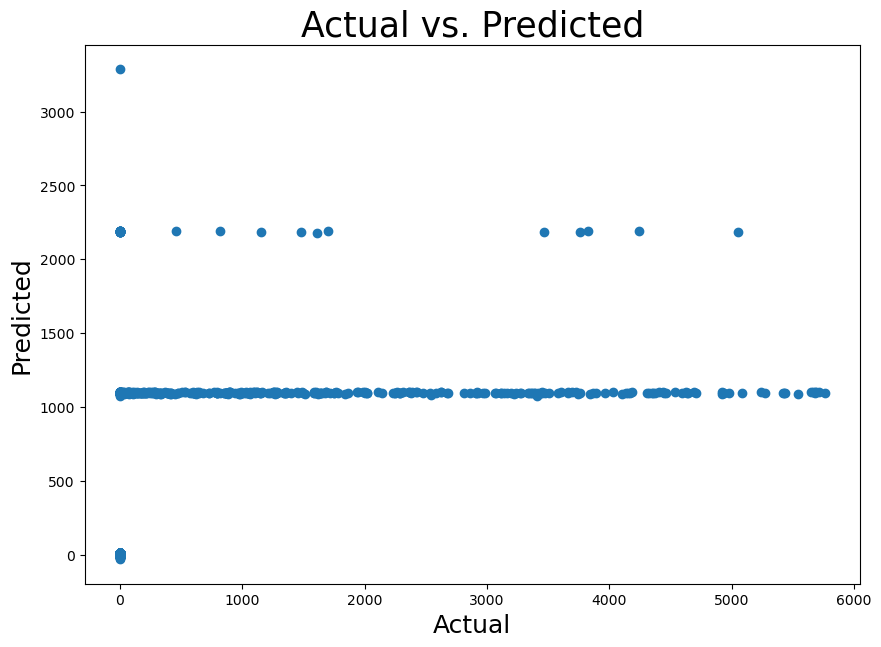

In [133]:
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    print("Intercept : ", model.intercept_)
    print("Slope : ", model.coef_)
    
    # Predicting TEST & TRAIN DATA
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    print("MAE")
    print("Train : ", mean_absolute_error(y_train, train_predict))
    print("Test  : ", mean_absolute_error(y_test, test_predict))
    print("====================================")
    
    print("MSE")
    print("Train : ", mean_squared_error(y_train, train_predict))
    print("Test  : ", mean_squared_error(y_test, test_predict))
    print("====================================")
    
    print("RMSE")
    print("Train : ", np.sqrt(mean_squared_error(y_train, train_predict)))
    print("Test  : ", np.sqrt(mean_squared_error(y_test, test_predict)))
    print("====================================")
    
    print("R2 SCORE")
    print("Train : ", r2_score(y_train, train_predict))
    print("Test  : ", r2_score(y_test, test_predict))  
    print("====================================")
    
    print("MAPE - Mean Absolute Percentage Error")
    train_y, train_predict = np.array(y_train), np.array(train_predict)
    print(np.mean(np.abs((y_train - train_predict) / y_train)) * 100)
    print("Mape - Train:" , np.mean(np.abs((y_train, train_predict))))
    print("Mape - Test:" ,np.mean(np.abs((y_test, test_predict))))
    
    # Plot actual vs predicted value
    plt.figure(figsize=(10, 7))
    plt.title("Actual vs. Predicted", fontsize=25)
    plt.xlabel("Actual", fontsize=18)
    plt.ylabel("Predicted", fontsize=18)
    plt.scatter(x=y_test, y=test_predict)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
lr = LinearRegression().fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print(lr.score(X_test, y_test))

In [98]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# Define the polynomial regression model
degree = 2  # Degree of the polynomial
poly_model = make_pipeline(PolynomialFeatures(degree), LinearRegression())

# Train the polynomial regression model
poly_model.fit(X_train, y_train)

# Make predictions
y_pred_poly = poly_model.predict(X_test)

# Evaluate the model
mse_poly = mean_squared_error(y_test, y_pred_poly)
print("Polynomial Regression Metrics:")
print(f"Mean Squared Error: {mse_poly}")

r2_poly = r2_score(y_test, y_pred_poly)
print(f"R-squared Score: {r2_poly}")


Polynomial Regression Metrics:
Mean Squared Error: 116059.2936774492
R-squared Score: 0.36698639761435525


In [100]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# Créer un pipeline pour la régression polynomiale avec régularisation Lasso
pipeline = Pipeline([
    ('poly_features', PolynomialFeatures(degree=3)),
    ('scaler', StandardScaler()),  # Standardiser les caractéristiques
    ('lasso_reg', LassoCV(cv=5))  # Lasso avec validation croisée
])

# Entraîner le modèle
pipeline.fit(X_train, y_train)

# Faire des prédictions
y_pred = pipeline.predict(X_test)

# Calculer les métriques d'évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Polynomial Regression with Lasso Regularization Metrics:")
print(f"Mean Squared Error: {mse}")
print(f"R-squared Score: {r2}")

Polynomial Regression with Lasso Regularization Metrics:
Mean Squared Error: 117164.69536584713
R-squared Score: 0.3609572871253611
